Our goal is to compare hue tuning properties of a give neuron across artificial and natural conditions. 

- For artificial condition, we simply fit a non-paramteric tuning curve as a density estimate of the spike count as a function of hue angle. We treat this as the **artificial tuning curve**. See **Section A**.

For natural conditions, it is difficult to estimate the presented hue from the fixated patch due to well-known issues of color constancy and color contrast. To this end, we take two different approaches. 

- First, we build a model based on the circular hue-histogram of the patch (along with nuisance variables). To this model, we present artificial hue patches encoded as a one-hot-vector corresponding to the histogram of a flat hue map, and treat the model prediction as the **natural tuning curve**. See **Section B**.


- Second, we build a model based on transfer learning from a pre-trained neural network (**VGG16**). We train separate Poisson gradient boosted regression models for four different pre-trained neural network codebooks: the last convolutional layer (**L5**), the two fully-connected layers (**L6**, **L7**) and the softmax layer (**L8**). We then present artificial hue patches (inputs encoded as RGB pixels) and compute the model predictions. We refer to these as the **synthetic tuning curve**. See **Section B**.

We then compare these tuning curves using a circular version of earth-mover's distance. See **Section C**.

## Imports

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
# compute
import numpy as np
import pandas as pd

# data io
import glob
import deepdish as dd
import sys
sys.path.append('../')

# image
import cv2

# plot
import matplotlib.pyplot as plt
%matplotlib inline

# spykes
from spykes.neuropop import NeuroPop
from spykes.neurovis import NeuroVis

# stats
from scipy.stats import circmean

# machine learning
import xgboost as xgb

# local
import V4pyutils as V4

/opt/anaconda/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 2: GeForce GTX TITAN X (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5103)


## Load merged sessions

### Filenames

In [2]:
h5path = '../V4pydata/H5data/M3/'
data = pd.read_excel('/home/klab/Projects/02-V4py/V4py/V4pydata/natural_artificial.xlsx')
data_M3 = data[data['Animal']=='M3']
data_M3

Animal                                    Natural  \
7      M3             Ro150125_s83a_FreeViewPic_0004   
8      M3             Ro150125_s83a_FreeViewPic_0005   
9      M3             Ro150127_s84a_FreeViewPic_0001   
10     M3             Ro150128_s85a_FreeViewPic_0001   
11     M3             Ro150129_s86a_FreeViewPic_0001   
12     M3             Ro150129_s86a_FreeViewPic_0005   
13     M3   Ro150210_s87a_FreeViewPic_manyimage_0004   
14     M3  Ro150211_s88a_FreeViewPic_manyimages_0004   
15     M3  Ro150211_s88a_FreeViewPic_manyimages_0005   
16     M3  Ro150212_289a_FreeViewPic_manyimages_0004   
17     M3             Ro150213_s90a_FreeViewPic_0004   
18     M3             Ro150216_s91a_FreeViewPic_0004   
19     M3             Ro150216_s91a_FreeViewPic_0005   
20     M3             Ro150217_s92a_FreeViewPic_0004   
21     M3             Ro150217_s92a_FreeViewPic_0005   

                             Hue                                Ori  \
7   Ro150126_s83a_huecircle_0003  Ro150126_s83a_v4fv_orituning_0002   
8   Ro150126_s83a_huecircle_0003  Ro150126_s83a_v4fv_orituning_0002   
9   Ro150127_s84a_huecircle_0003  Ro150127_s84a_v4fv_orituning_0002   
10  Ro150128_s85a_huecircle_0003  Ro150128_s85a_v4fv_orituning_0002   
11  Ro150129_s86a_huecircle_0003  Ro150129_s86a_v4fv_orituning_0002   
12  Ro150129_s86a_huecircle_0003  Ro150129_s86a_v4fv_orituning_0002   
13  Ro150210_s87a_huecircle_0003  Ro150210_s87a_v4fv_orituning_0002   
14  Ro150211_s88a_huecircle_0003  Ro150211_s88a_v4fv_orituning_0002   
15  Ro150211_s88a_huecircle_0003  Ro150211_s88a_v4fv_orituning_0002   
16  Ro150212_289a_huecircle_0003  Ro150212_289a_v4fr_orituning_0002   
17  Ro150213_s90a_huecircle_0003  Ro150213_s90a_v4fv_orituning_0002   
18  Ro150216_s91a_huecircle_0003  Ro150216_s91a_v4fv_orituning_0002   
19  Ro150216_s91a_huecircle_0003  Ro150216_s91a_v4fv_orituning_0002   
20  Ro150217_s92a_huecircle_0003  Ro150217_s92a_v4fv_orituning_0002   
21  Ro150217_s92a_huecircle_0003  Ro150217_s92a_v4fv_orituning_0002   

                              RF  
7   Ro150126_s83a_rfMapping_0001  
8   Ro150126_s83a_rfMapping_0001  
9   Ro150127_s84a_rfMapping_0001  
10  Ro150128_s85a_rfMapping_0001  
11  Ro150129_s86a_rfMapping_0001  
12  Ro150129_s86a_rfMapping_0001  
13  Ro150210_s87a_rfMapping_0001  
14  Ro150211_s88a_rfMapping_0001  
15  Ro150211_s88a_rfMapping_0001  
16  Ro150212_289a_rfMapping_0001  
17  Ro150213_s90a_rfMapping_0001  
18  Ro150216_s91a_rfMapping_0001  
19  Ro150216_s91a_rfMapping_0001  
20  Ro150217_s92a_rfMapping_0001  
21  Ro150217_s92a_rfMapping_0001

### All sessions

In [3]:
df = pd.read_pickle('../02-preprocessed_data/M3/merged_art_data_across_sessions_orientation')

# Correct for orientation angle > 180 deg.
df['predictors.ori'] = np.where(df['predictors.ori'] >= 180.0,
                                df['predictors.ori'] - 180.0,
                                df['predictors.ori'])
df['predictors.ori_prev'] = np.where(df['predictors.ori_prev'] >= 180.0,
                                     df['predictors.ori_prev'] - 180.0,
                                     df['predictors.ori_prev'])
df.head()


predictors.onset_times  predictors.offset_times  predictors.col  \
0               17.794800                18.079600           521.0   
1               18.398067                18.690333           590.0   
2               19.011833                19.299400           670.0   
3               19.618200                19.909533           641.0   
4               20.248333                20.545200           621.0   

   predictors.row  predictors.ori  predictors.ori_prev  predictors.stim_dur  \
0           521.0           112.0               -999.0             0.284800   
1           590.0           157.0                112.0             0.292267   
2           670.0            67.0                157.0             0.287567   
3           641.0            67.0                 67.0             0.291333   
4           621.0           112.0                 67.0             0.296867   

   predictors.off_to_onset_times  spikes.0101  spikes.0201       ...        \
0                    -999.000000          NaN          NaN       ...         
1                       0.318467          NaN          NaN       ...         
2                       0.321500          NaN          NaN       ...         
3                       0.318800          NaN          NaN       ...         
4                       0.338800          NaN          NaN       ...         

   spikes.9002  spikes.9100  spikes.9102  spikes.9200  spikes.9202  \
0          NaN         11.0          NaN         11.0          NaN   
1          NaN         11.0          NaN         11.0          NaN   
2          NaN          8.0          NaN          8.0          NaN   
3          NaN          7.0          NaN          7.0          NaN   
4          NaN          2.0          NaN          2.0          NaN   

   spikes.9300  spikes.9400  spikes.9600  \
0          NaN          NaN          3.0   
1          NaN          NaN          2.0   
2          NaN          NaN          4.0   
3          NaN          NaN          1.0   
4          NaN          NaN          3.0   

                                        session.name  session.number  
0  ../V4pydata/H5data/M3/Ro150126_s83a_v4fv_oritu...               0  
1  ../V4pydata/H5data/M3/Ro150126_s83a_v4fv_oritu...               0  
2  ../V4pydata/H5data/M3/Ro150126_s83a_v4fv_oritu...               0  
3  ../V4pydata/H5data/M3/Ro150126_s83a_v4fv_oritu...               0  
4  ../V4pydata/H5data/M3/Ro150126_s83a_v4fv_oritu...               0  

[5 rows x 117 columns]

### Merging table

In [4]:
df_neurons = pd.read_pickle('../02-preprocessed_data/M3/data_to_combine_across_sessions')
df_neurons.head()
#print df_neurons.loc[39]['art_filenames']
#print df_neurons.loc[39]['art_sessions']

name  art_sessions  \
0  spikes.0101        [2, 3]   
1  spikes.0301        [8, 9]   
2  spikes.0500     [3, 4, 5]   
3  spikes.0500     [4, 5, 6]   
4  spikes.0600  [2, 3, 4, 5]   

                                       art_filenames nat_sessions  \
0  [Ro150127_s84a_huecircle_0003, Ro150128_s85a_h...          [4]   
1  [Ro150211_s88a_huecircle_0003, Ro150212_289a_h...     [11, 12]   
2  [Ro150128_s85a_huecircle_0003, Ro150129_s86a_h...       [5, 6]   
3  [Ro150129_s86a_huecircle_0003, Ro150129_s86a_h...    [6, 7, 8]   
4  [Ro150127_s84a_huecircle_0003, Ro150128_s85a_h...    [4, 5, 6]   

                                       nat_filenames  
0                   [Ro150129_s86a_FreeViewPic_0001]  
1  [Ro150216_s91a_FreeViewPic_0004, Ro150216_s91a...  
2  [Ro150129_s86a_FreeViewPic_0005, Ro150210_s87a...  
3  [Ro150210_s87a_FreeViewPic_manyimage_0004, Ro1...  
4  [Ro150129_s86a_FreeViewPic_0001, Ro150129_s86a...

## A. Artificial tuning curves

### Fit models for each neuron

0 spikes.0101
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0724950106919
...runnning cv-fold 2 of 2
pseudo_R2:  0.0037771834604
pseudo_R2_cv: 0.038136 (+/- 0.024295)
------------------------------------------------------------



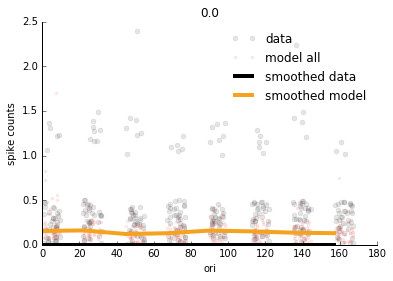

1 spikes.0301
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0877322467138
...runnning cv-fold 2 of 2
pseudo_R2:  0.0765589331445
pseudo_R2_cv: 0.082146 (+/- 0.003950)
------------------------------------------------------------



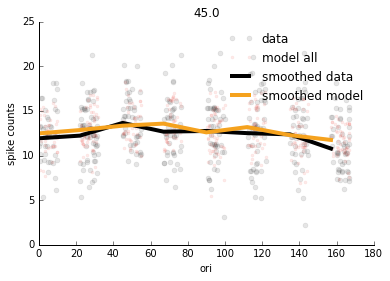

2 spikes.0500
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.164305084384
...runnning cv-fold 2 of 3
pseudo_R2:  0.185169099142
...runnning cv-fold 3 of 3
pseudo_R2:  0.232529942377
pseudo_R2_cv: 0.084465 (+/- 0.102171)
------------------------------------------------------------



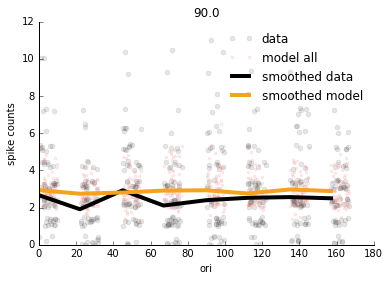

3 spikes.0500
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.280337090405
...runnning cv-fold 2 of 3
pseudo_R2:  0.345007791955
...runnning cv-fold 3 of 3
pseudo_R2:  -0.603770973221
pseudo_R2_cv: -0.179700 (+/- 0.227372)
------------------------------------------------------------



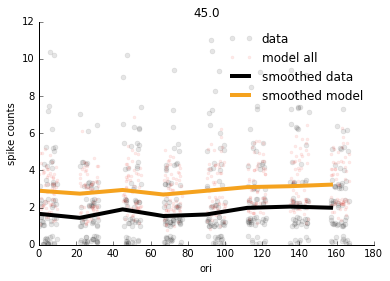

4 spikes.0600
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  -0.189620184279
...runnning cv-fold 2 of 4
pseudo_R2:  -0.68671000369
...runnning cv-fold 3 of 4
pseudo_R2:  -0.586268690375
...runnning cv-fold 4 of 4
pseudo_R2:  -0.235377462502
pseudo_R2_cv: -0.424494 (+/- 0.107778)
------------------------------------------------------------



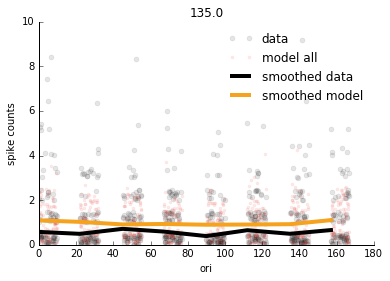

5 spikes.0700
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  -1.45192108005
...runnning cv-fold 2 of 4
pseudo_R2:  -0.0367941412168
...runnning cv-fold 3 of 4
pseudo_R2:  -0.498076603716
...runnning cv-fold 4 of 4
pseudo_R2:  -0.713556556887
pseudo_R2_cv: -0.675087 (+/- 0.255404)
------------------------------------------------------------



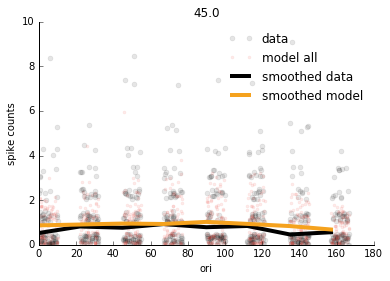

6 spikes.0700
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0870555174964
...runnning cv-fold 2 of 2
pseudo_R2:  -0.432382854793
pseudo_R2_cv: -0.259719 (+/- 0.122092)
------------------------------------------------------------



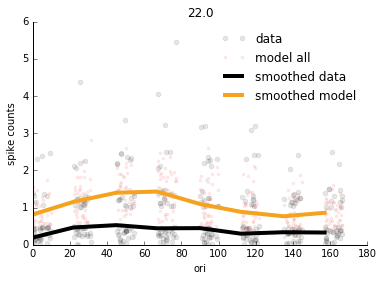

7 spikes.0700
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.126012424528
...runnning cv-fold 2 of 2
pseudo_R2:  0.269698757398
pseudo_R2_cv: 0.197856 (+/- 0.050801)
------------------------------------------------------------



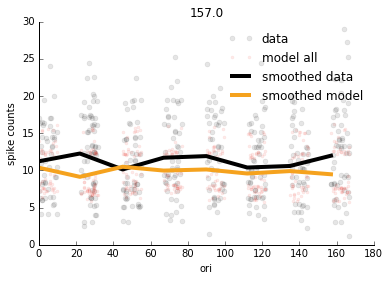

8 spikes.0900
9 spikes.0900
10 spikes.0900
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.776952854828
...runnning cv-fold 2 of 3
pseudo_R2:  -0.74641725828
...runnning cv-fold 3 of 3
pseudo_R2:  0.0274804975639
pseudo_R2_cv: -0.498630 (+/- 0.214904)
------------------------------------------------------------



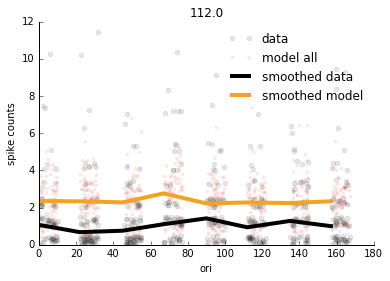

11 spikes.1100
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.291073675856
...runnning cv-fold 2 of 2
pseudo_R2:  0.197879229223
pseudo_R2_cv: 0.244476 (+/- 0.032949)
------------------------------------------------------------



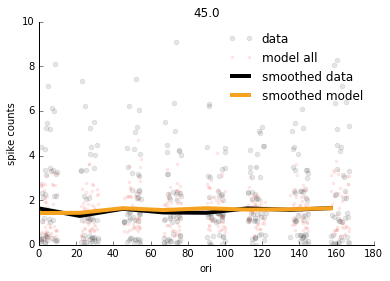

12 spikes.1400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.302602025302
...runnning cv-fold 2 of 2
pseudo_R2:  0.333151340536
pseudo_R2_cv: 0.317877 (+/- 0.010801)
------------------------------------------------------------



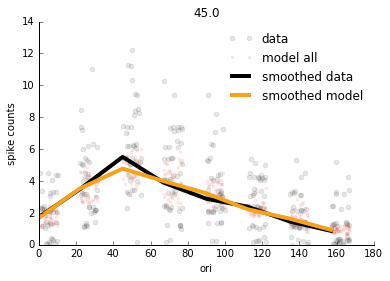

13 spikes.1400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.278837624492
...runnning cv-fold 2 of 2
pseudo_R2:  0.119475464261
pseudo_R2_cv: 0.199157 (+/- 0.056343)
------------------------------------------------------------



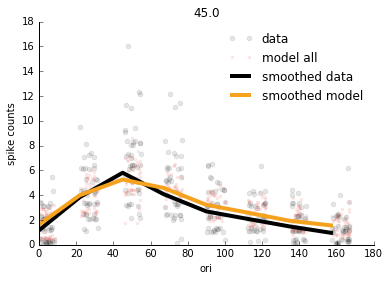

14 spikes.1400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.0831240055059
...runnning cv-fold 2 of 3
pseudo_R2:  -0.452447558053
...runnning cv-fold 3 of 3
pseudo_R2:  0.210758602272
pseudo_R2_cv: -0.052855 (+/- 0.165884)
------------------------------------------------------------



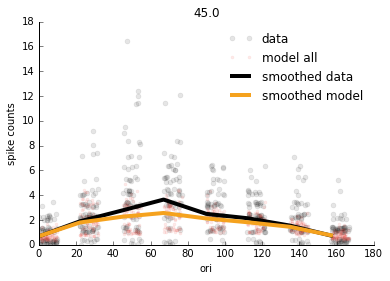

15 spikes.1500
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.0209801535929
...runnning cv-fold 2 of 3
pseudo_R2:  -0.0881734610112
...runnning cv-fold 3 of 3
pseudo_R2:  -0.0573306209033
pseudo_R2_cv: -0.041508 (+/- 0.026526)
------------------------------------------------------------



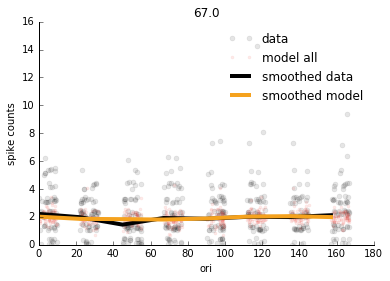

16 spikes.1500
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0196113544067
...runnning cv-fold 2 of 2
pseudo_R2:  0.124580463478
pseudo_R2_cv: 0.052485 (+/- 0.050980)
------------------------------------------------------------



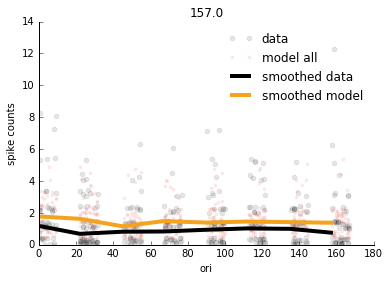

17 spikes.1701
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0932847425608
...runnning cv-fold 2 of 2
pseudo_R2:  -0.506753797221
pseudo_R2_cv: -0.300019 (+/- 0.146183)
------------------------------------------------------------



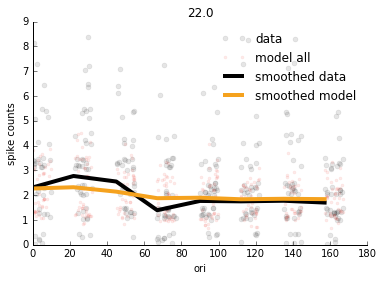

18 spikes.2101
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0724556558133
...runnning cv-fold 2 of 2
pseudo_R2:  0.0491246107562
pseudo_R2_cv: 0.060790 (+/- 0.008249)
------------------------------------------------------------



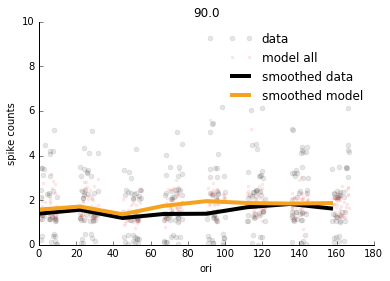

19 spikes.2501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0011475883928
...runnning cv-fold 2 of 2
pseudo_R2:  -0.374678996875
pseudo_R2_cv: -0.187913 (+/- 0.132063)
------------------------------------------------------------



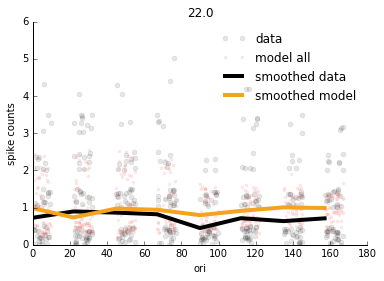

20 spikes.2801
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.3529756993
...runnning cv-fold 2 of 2
pseudo_R2:  0.23909461349
pseudo_R2_cv: 0.296035 (+/- 0.040263)
------------------------------------------------------------



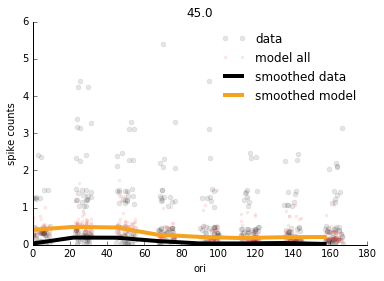

21 spikes.2901
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.114461939044
...runnning cv-fold 2 of 2
pseudo_R2:  -0.457862793877
pseudo_R2_cv: -0.171700 (+/- 0.202347)
------------------------------------------------------------



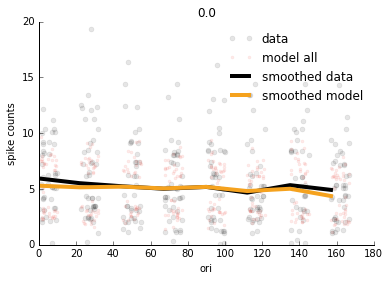

22 spikes.2901
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.119583949203
...runnning cv-fold 2 of 2
pseudo_R2:  0.0907171242449
pseudo_R2_cv: 0.105151 (+/- 0.010206)
------------------------------------------------------------



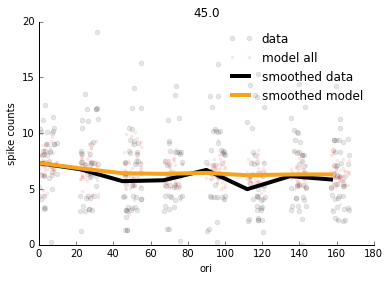

23 spikes.3201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.254823353466
...runnning cv-fold 2 of 2
pseudo_R2:  -0.102035041004
pseudo_R2_cv: 0.076394 (+/- 0.126168)
------------------------------------------------------------



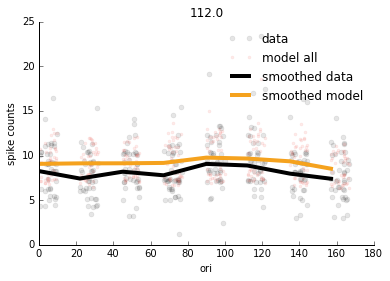

24 spikes.3201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.078174020701
...runnning cv-fold 2 of 2
pseudo_R2:  0.140430987995
pseudo_R2_cv: 0.109303 (+/- 0.022011)
------------------------------------------------------------



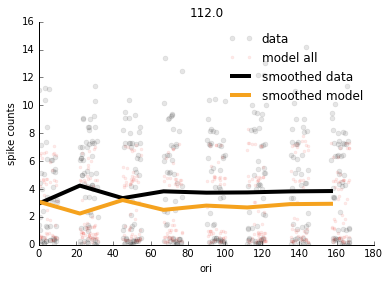

25 spikes.3401
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.248082781912
...runnning cv-fold 2 of 2
pseudo_R2:  -0.0846256489608
pseudo_R2_cv: 0.081729 (+/- 0.117630)
------------------------------------------------------------



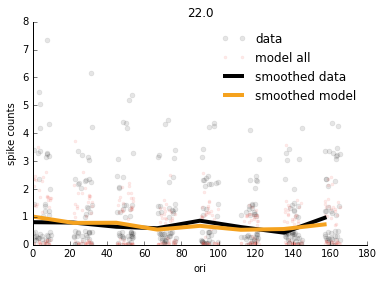

26 spikes.3401
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.410757400993
...runnning cv-fold 2 of 2
pseudo_R2:  -0.355106777261
pseudo_R2_cv: 0.027825 (+/- 0.270774)
------------------------------------------------------------



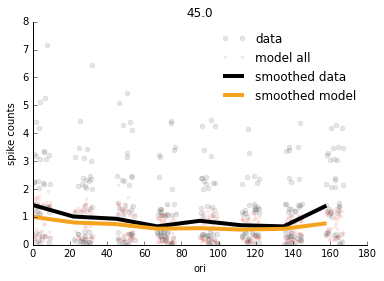

27 spikes.3601
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.194168889695
...runnning cv-fold 2 of 2
pseudo_R2:  -0.0815340024768
pseudo_R2_cv: -0.137851 (+/- 0.039822)
------------------------------------------------------------



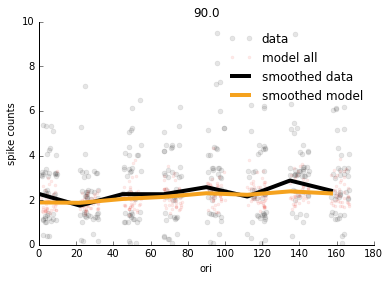

28 spikes.3701
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.283608645579
...runnning cv-fold 2 of 2
pseudo_R2:  -0.111972540285
pseudo_R2_cv: -0.197791 (+/- 0.060683)
------------------------------------------------------------



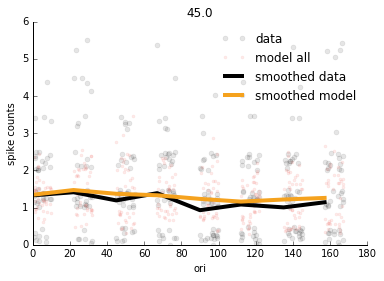

29 spikes.3701
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  0.291437386134
...runnning cv-fold 2 of 4
pseudo_R2:  -1.03313116467
...runnning cv-fold 3 of 4
pseudo_R2:  -0.774955973183
...runnning cv-fold 4 of 4
pseudo_R2:  0.0870967480572
pseudo_R2_cv: -0.357388 (+/- 0.279456)
------------------------------------------------------------



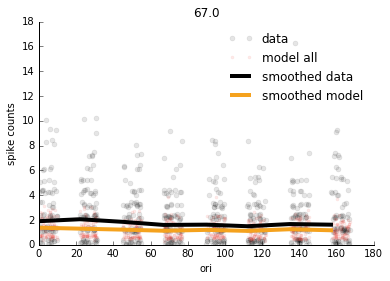

30 spikes.3701
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.0978678951447
...runnning cv-fold 2 of 3
pseudo_R2:  0.288349604626
...runnning cv-fold 3 of 3
pseudo_R2:  -0.292650351832
pseudo_R2_cv: -0.034056 (+/- 0.139399)
------------------------------------------------------------



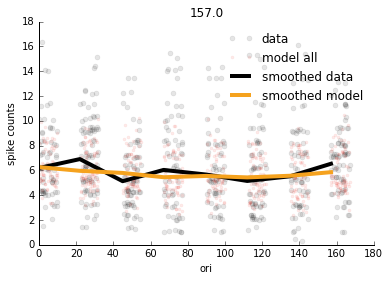

31 spikes.3801
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.215243458216
...runnning cv-fold 2 of 2
pseudo_R2:  -0.0704861017198
pseudo_R2_cv: -0.142865 (+/- 0.051179)
------------------------------------------------------------



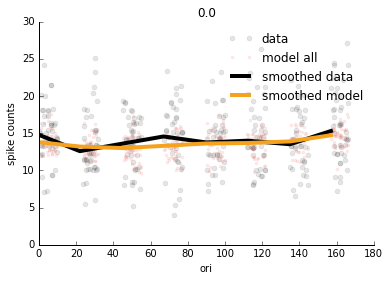

32 spikes.3801
33 spikes.3901
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.182107686645
...runnning cv-fold 2 of 2
pseudo_R2:  0.866456630255
pseudo_R2_cv: 0.342174 (+/- 0.370723)
------------------------------------------------------------



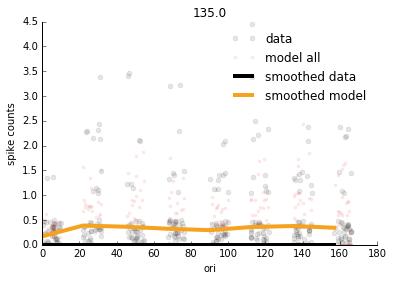

34 spikes.3901
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0436879714547
...runnning cv-fold 2 of 2
pseudo_R2:  0.182577431191
pseudo_R2_cv: 0.113133 (+/- 0.049105)
------------------------------------------------------------



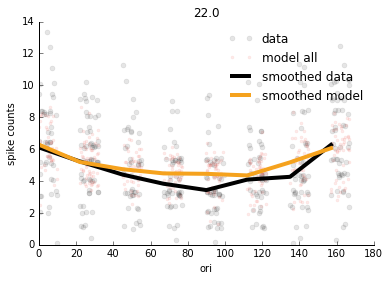

35 spikes.4301
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.847167615962
...runnning cv-fold 2 of 2
pseudo_R2:  -0.239750501507
pseudo_R2_cv: -0.543459 (+/- 0.214754)
------------------------------------------------------------



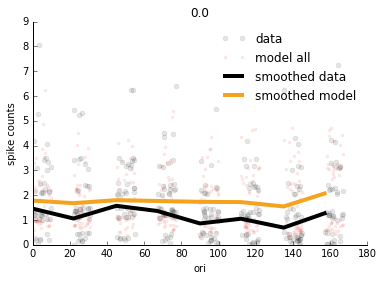

36 spikes.4301
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0454199507902
...runnning cv-fold 2 of 2
pseudo_R2:  -0.190981141199
pseudo_R2_cv: -0.072781 (+/- 0.083580)
------------------------------------------------------------



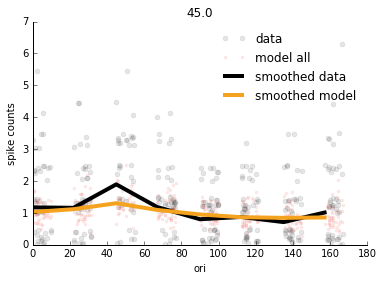

37 spikes.4401
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  -0.277180236865
...runnning cv-fold 2 of 4
pseudo_R2:  -1.53815727478
...runnning cv-fold 3 of 4
pseudo_R2:  0.0774004514806
...runnning cv-fold 4 of 4
pseudo_R2:  -0.456100285106
pseudo_R2_cv: -0.548509 (+/- 0.301385)
------------------------------------------------------------



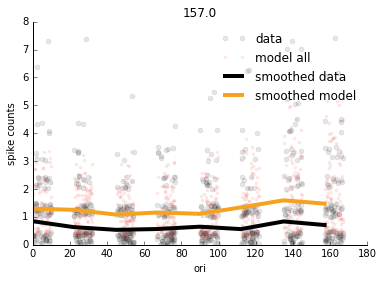

38 spikes.4501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.131620694761
...runnning cv-fold 2 of 2
pseudo_R2:  0.0809738840252
pseudo_R2_cv: 0.106297 (+/- 0.017906)
------------------------------------------------------------



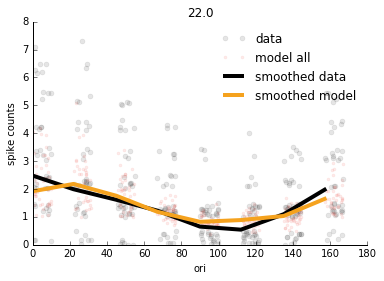

39 spikes.4501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  0.216654784958
...runnning cv-fold 2 of 4
pseudo_R2:  0.344060865035
...runnning cv-fold 3 of 4
pseudo_R2:  0.20908554477
...runnning cv-fold 4 of 4
pseudo_R2:  0.277200386275
pseudo_R2_cv: 0.261750 (+/- 0.027181)
------------------------------------------------------------



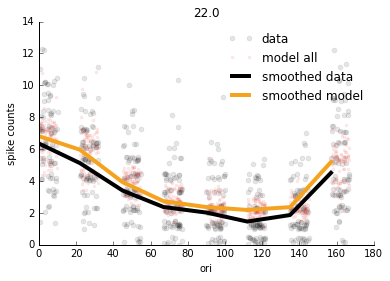

40 spikes.4501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.083203131759
...runnning cv-fold 2 of 2
pseudo_R2:  0.23701309728
pseudo_R2_cv: 0.160108 (+/- 0.054380)
------------------------------------------------------------



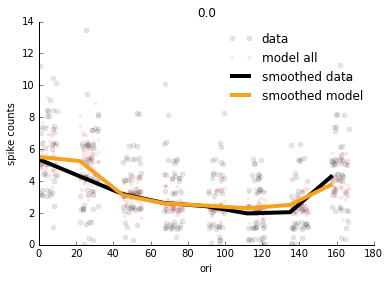

41 spikes.4501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.163990658324
...runnning cv-fold 2 of 2
pseudo_R2:  0.0700672799481
pseudo_R2_cv: 0.117029 (+/- 0.033207)
------------------------------------------------------------



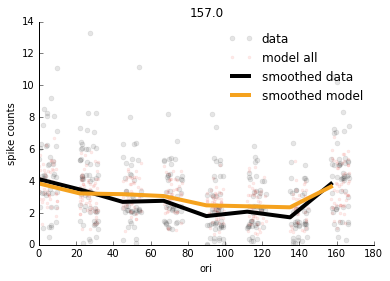

42 spikes.4701
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.0697345820816
...runnning cv-fold 2 of 3
pseudo_R2:  0.0914385747376
...runnning cv-fold 3 of 3
pseudo_R2:  0.109522459754
pseudo_R2_cv: 0.090232 (+/- 0.009391)
------------------------------------------------------------



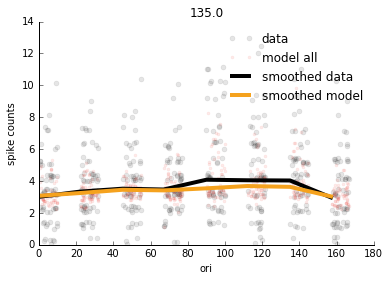

43 spikes.4701
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0832209012877
...runnning cv-fold 2 of 2
pseudo_R2:  0.105169467923
pseudo_R2_cv: 0.010974 (+/- 0.066606)
------------------------------------------------------------



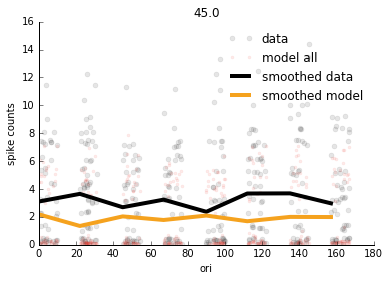

44 spikes.4901
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0672770018983
...runnning cv-fold 2 of 2
pseudo_R2:  -0.131864126399
pseudo_R2_cv: -0.099571 (+/- 0.022835)
------------------------------------------------------------



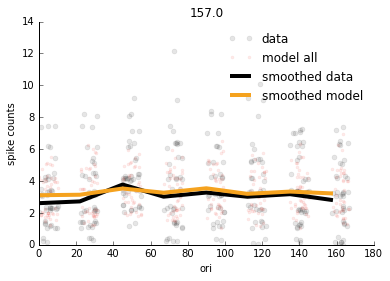

45 spikes.4901
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.000919282604188
...runnning cv-fold 2 of 2
pseudo_R2:  0.0725594554664
pseudo_R2_cv: 0.035820 (+/- 0.025979)
------------------------------------------------------------



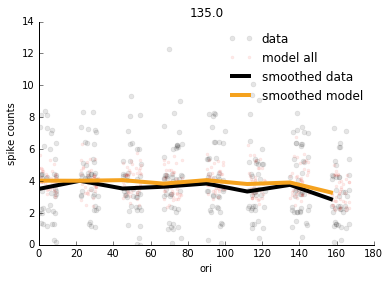

46 spikes.5101
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.0217408586584
...runnning cv-fold 2 of 3
pseudo_R2:  0.0648480554043
...runnning cv-fold 3 of 3
pseudo_R2:  0.158025650194
pseudo_R2_cv: 0.067044 (+/- 0.042381)
------------------------------------------------------------



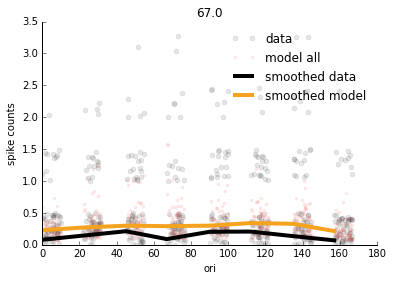

47 spikes.5101
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0345918377425
...runnning cv-fold 2 of 2
pseudo_R2:  0.118661777299
pseudo_R2_cv: 0.042035 (+/- 0.054183)
------------------------------------------------------------



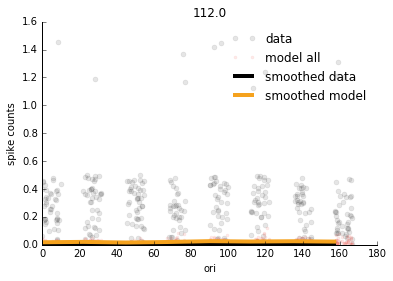

48 spikes.5201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -1.24063062352
...runnning cv-fold 2 of 3
pseudo_R2:  0.0440619268996
...runnning cv-fold 3 of 3
pseudo_R2:  -0.578676154803
pseudo_R2_cv: -0.591748 (+/- 0.302852)
------------------------------------------------------------



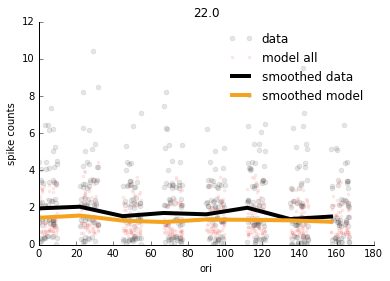

49 spikes.5201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0887584042597
...runnning cv-fold 2 of 2
pseudo_R2:  0.0763350497199
pseudo_R2_cv: 0.082547 (+/- 0.004392)
------------------------------------------------------------



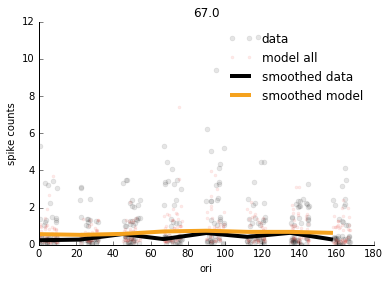

50 spikes.5201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0306694765698
...runnning cv-fold 2 of 2
pseudo_R2:  0.115725833793
pseudo_R2_cv: 0.073198 (+/- 0.030072)
------------------------------------------------------------



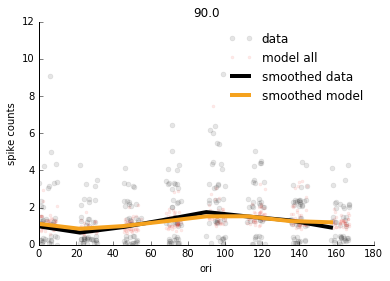

51 spikes.5201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.188931546722
...runnning cv-fold 2 of 2
pseudo_R2:  0.112634762803
pseudo_R2_cv: -0.038148 (+/- 0.106620)
------------------------------------------------------------



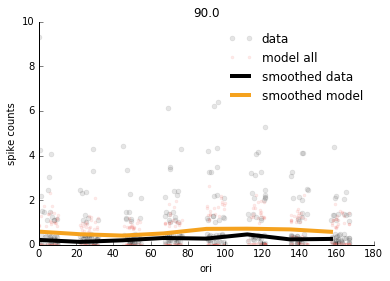

52 spikes.5301
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 5
pseudo_R2:  -0.146994300732
...runnning cv-fold 2 of 5
pseudo_R2:  -0.0114229342847
...runnning cv-fold 3 of 5
pseudo_R2:  -0.244155613591
...runnning cv-fold 4 of 5
pseudo_R2:  -0.218631808309
...runnning cv-fold 5 of 5
pseudo_R2:  -0.264576887458
pseudo_R2_cv: -0.177156 (+/- 0.041099)
------------------------------------------------------------



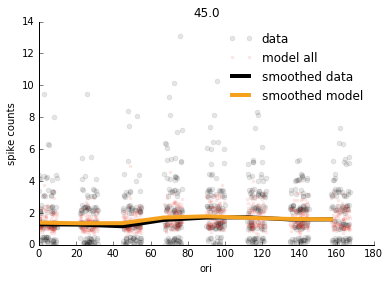

53 spikes.5301
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0204624944644
...runnning cv-fold 2 of 2
pseudo_R2:  -0.0167765747172
pseudo_R2_cv: -0.018620 (+/- 0.001303)
------------------------------------------------------------



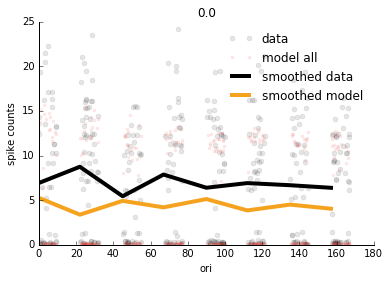

54 spikes.5401
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0927614466163
...runnning cv-fold 2 of 2
pseudo_R2:  -0.130359438411
pseudo_R2_cv: -0.111560 (+/- 0.013293)
------------------------------------------------------------



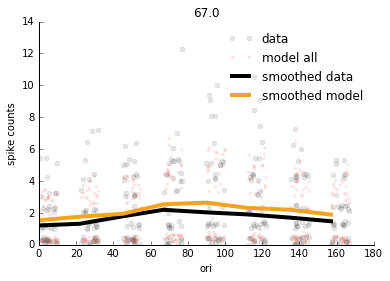

55 spikes.5401
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  -0.215487543927
...runnning cv-fold 2 of 4
pseudo_R2:  0.383348645848
...runnning cv-fold 3 of 4
pseudo_R2:  -1.54782032605
...runnning cv-fold 4 of 4
pseudo_R2:  -0.732483313344
pseudo_R2_cv: -0.528111 (+/- 0.354442)
------------------------------------------------------------



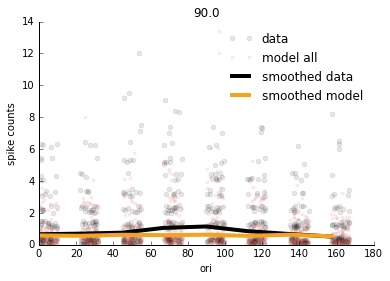

56 spikes.5401
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.285967161069
...runnning cv-fold 2 of 2
pseudo_R2:  -0.00718782530471
pseudo_R2_cv: -0.146577 (+/- 0.098563)
------------------------------------------------------------



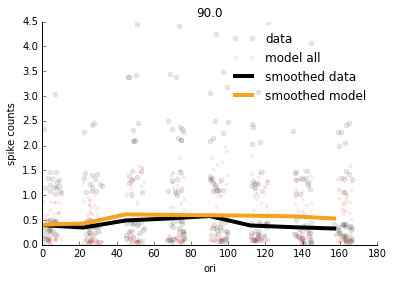

57 spikes.5501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.102789800931
...runnning cv-fold 2 of 2
pseudo_R2:  -0.0974941895684
pseudo_R2_cv: -0.100142 (+/- 0.001872)
------------------------------------------------------------



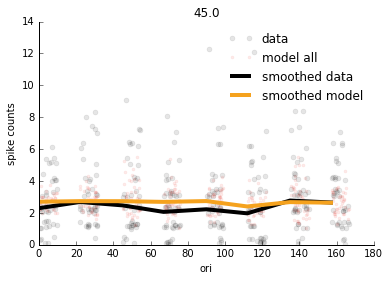

58 spikes.5501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.163134676238
...runnning cv-fold 2 of 2
pseudo_R2:  -0.125365462097
pseudo_R2_cv: -0.144250 (+/- 0.013353)
------------------------------------------------------------



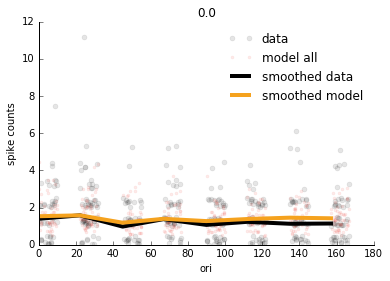

59 spikes.5601
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.084677751252
...runnning cv-fold 2 of 2
pseudo_R2:  -0.0908798599841
pseudo_R2_cv: -0.003101 (+/- 0.062069)
------------------------------------------------------------



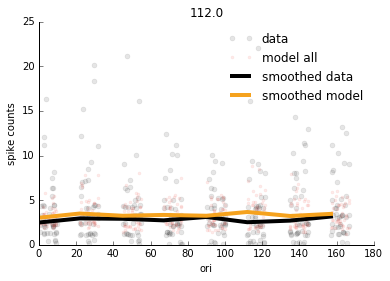

60 spikes.5601
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.291445413124
...runnning cv-fold 2 of 2
pseudo_R2:  -0.14842685321
pseudo_R2_cv: -0.219936 (+/- 0.050565)
------------------------------------------------------------



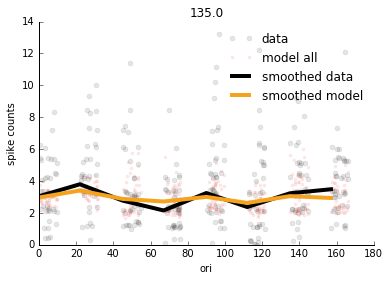

61 spikes.5601
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.089254427845
...runnning cv-fold 2 of 2
pseudo_R2:  -0.00828461231918
pseudo_R2_cv: -0.048770 (+/- 0.028627)
------------------------------------------------------------



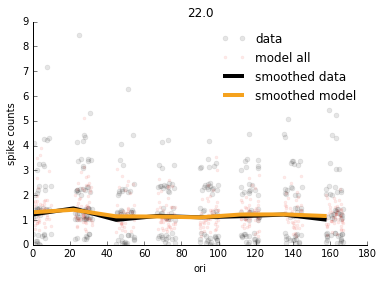

62 spikes.5801
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  -0.281078557053
...runnning cv-fold 2 of 4
pseudo_R2:  -0.230047005824
...runnning cv-fold 3 of 4
pseudo_R2:  -1.45423285678
...runnning cv-fold 4 of 4
pseudo_R2:  -0.0626884994381
pseudo_R2_cv: -0.507012 (+/- 0.276406)
------------------------------------------------------------



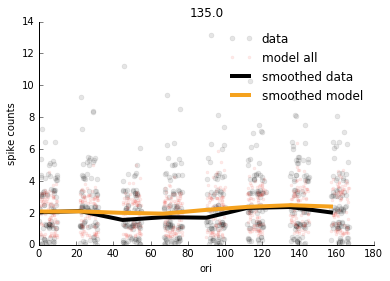

63 spikes.5801
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 5
pseudo_R2:  0.0753167736136
...runnning cv-fold 2 of 5
pseudo_R2:  -0.198402901289
...runnning cv-fold 3 of 5
pseudo_R2:  -2.51881425704
...runnning cv-fold 4 of 5
pseudo_R2:  -0.431296118368
...runnning cv-fold 5 of 5
pseudo_R2:  0.219288613257
pseudo_R2_cv: -0.570782 (+/- 0.446972)
------------------------------------------------------------



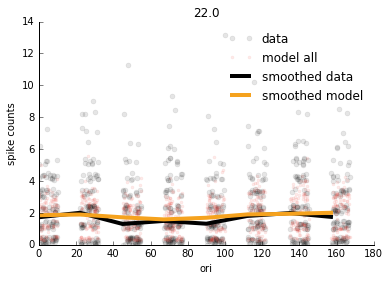

64 spikes.6101
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.411815905944
...runnning cv-fold 2 of 2
pseudo_R2:  0.0991497840686
pseudo_R2_cv: -0.156333 (+/- 0.180654)
------------------------------------------------------------



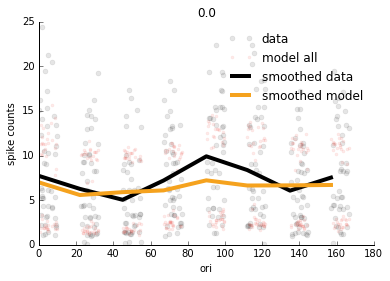

65 spikes.6201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.000597301253075
...runnning cv-fold 2 of 2
pseudo_R2:  0.100689956673
pseudo_R2_cv: 0.050046 (+/- 0.035810)
------------------------------------------------------------



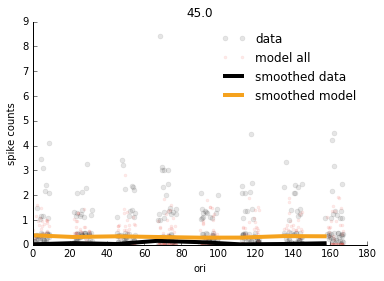

66 spikes.6400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.339141659736
...runnning cv-fold 2 of 2
pseudo_R2:  -0.100644090158
pseudo_R2_cv: -0.219893 (+/- 0.084322)
------------------------------------------------------------



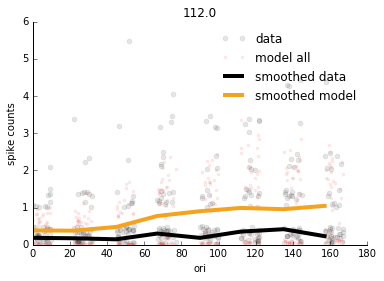

67 spikes.6400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.27245798951
...runnning cv-fold 2 of 2
pseudo_R2:  -0.0633327550685
pseudo_R2_cv: -0.167895 (+/- 0.073937)
------------------------------------------------------------



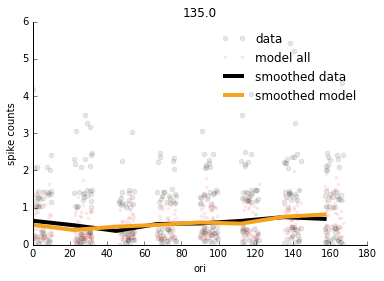

68 spikes.7300
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0396377810734
...runnning cv-fold 2 of 2
pseudo_R2:  0.222716825634
pseudo_R2_cv: 0.131177 (+/- 0.064728)
------------------------------------------------------------



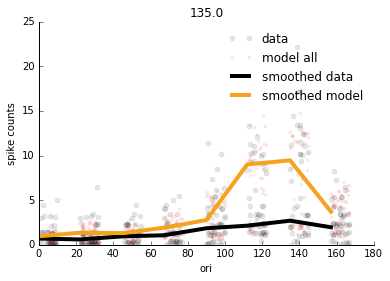

69 spikes.7500
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.190837330027
...runnning cv-fold 2 of 2
pseudo_R2:  -0.178219245591
pseudo_R2_cv: -0.184528 (+/- 0.004461)
------------------------------------------------------------



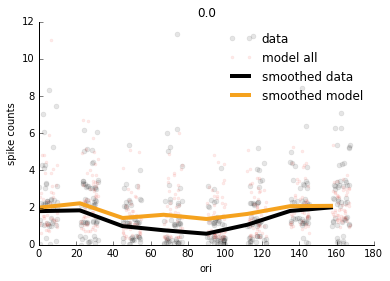

70 spikes.7800
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.274858601009
...runnning cv-fold 2 of 2
pseudo_R2:  -1.18291916579
pseudo_R2_cv: -0.728889 (+/- 0.321048)
------------------------------------------------------------



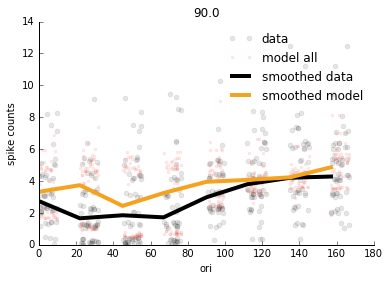

71 spikes.8000
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.159577468957
...runnning cv-fold 2 of 2
pseudo_R2:  0.142814679469
pseudo_R2_cv: 0.151196 (+/- 0.005927)
------------------------------------------------------------



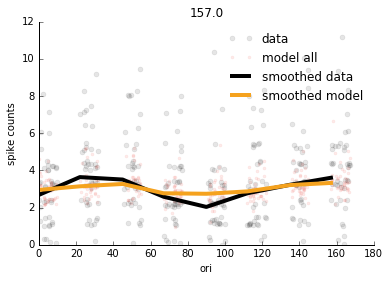

72 spikes.8100
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.462921811967
...runnning cv-fold 2 of 2
pseudo_R2:  0.339101250541
pseudo_R2_cv: 0.401012 (+/- 0.043777)
------------------------------------------------------------



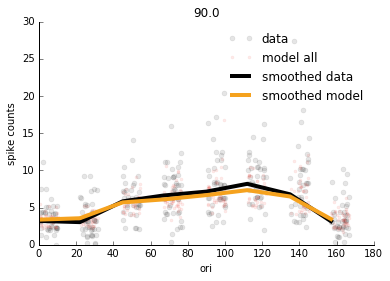

73 spikes.8300
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.114925104755
...runnning cv-fold 2 of 2
pseudo_R2:  -0.0392026575805
pseudo_R2_cv: -0.077064 (+/- 0.026772)
------------------------------------------------------------



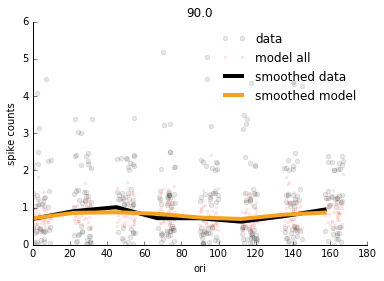

74 spikes.8300
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.0133971419213
...runnning cv-fold 2 of 3
pseudo_R2:  -0.0511510652689
...runnning cv-fold 3 of 3
pseudo_R2:  0.128449793319
pseudo_R2_cv: 0.030232 (+/- 0.042887)
------------------------------------------------------------



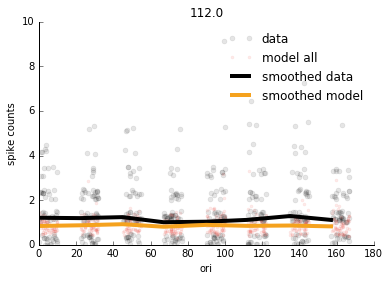

75 spikes.8400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0404683092482
...runnning cv-fold 2 of 2
pseudo_R2:  0.0943380743563
pseudo_R2_cv: 0.026935 (+/- 0.047661)
------------------------------------------------------------



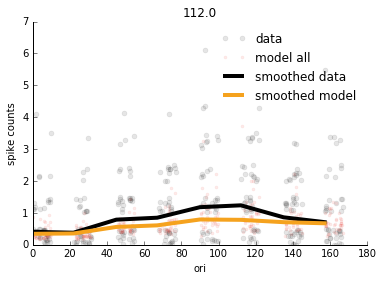

76 spikes.8400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.0482628696926
...runnning cv-fold 2 of 3
pseudo_R2:  0.171998426488
...runnning cv-fold 3 of 3
pseudo_R2:  -0.462140779771
pseudo_R2_cv: -0.112802 (+/- 0.151773)
------------------------------------------------------------



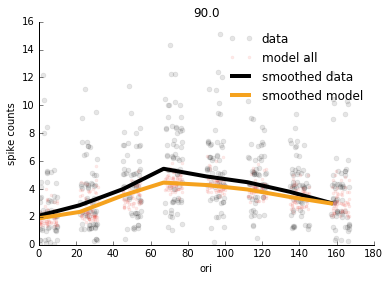

77 spikes.8600
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0128327466
...runnning cv-fold 2 of 2
pseudo_R2:  -0.208937271366
pseudo_R2_cv: -0.098052 (+/- 0.078408)
------------------------------------------------------------



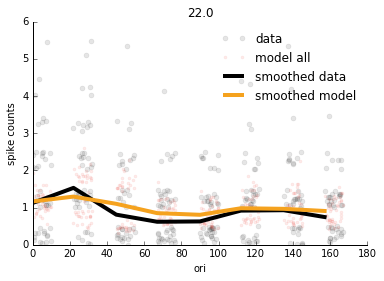

78 spikes.8700
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0490217945737
...runnning cv-fold 2 of 2
pseudo_R2:  0.0691449617292
pseudo_R2_cv: 0.010062 (+/- 0.041778)
------------------------------------------------------------



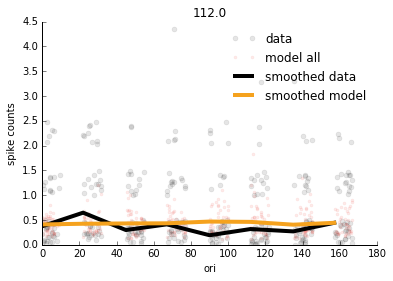

79 spikes.8700
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 5
pseudo_R2:  0.0490782722503
...runnning cv-fold 2 of 5
pseudo_R2:  0.0572155221977
...runnning cv-fold 3 of 5
pseudo_R2:  -0.222725935554
...runnning cv-fold 4 of 5
pseudo_R2:  0.0400100348618
...runnning cv-fold 5 of 5
pseudo_R2:  -0.0243923032759
pseudo_R2_cv: -0.020163 (+/- 0.047097)
------------------------------------------------------------



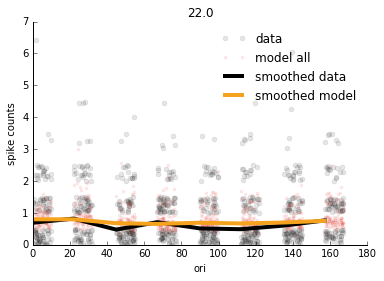

80 spikes.8800
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0882975697343
...runnning cv-fold 2 of 2
pseudo_R2:  -0.309925282985
pseudo_R2_cv: -0.199111 (+/- 0.078357)
------------------------------------------------------------



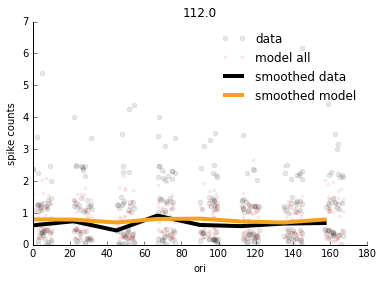

81 spikes.9000
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.00500774748243
...runnning cv-fold 2 of 3
pseudo_R2:  0.115564173838
...runnning cv-fold 3 of 3
pseudo_R2:  -0.0244084803809
pseudo_R2_cv: 0.028716 (+/- 0.035749)
------------------------------------------------------------



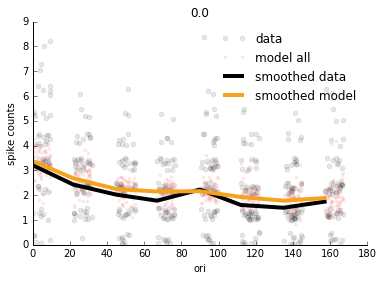

82 spikes.9000
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0269083115646
...runnning cv-fold 2 of 2
pseudo_R2:  -0.346141758264
pseudo_R2_cv: -0.159617 (+/- 0.131893)
------------------------------------------------------------



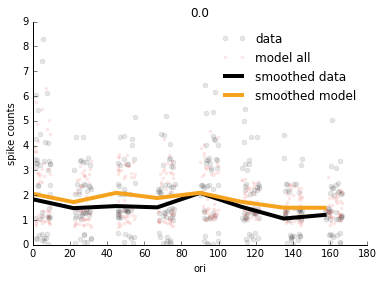

83 spikes.9000
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.0536919566924
...runnning cv-fold 2 of 3
pseudo_R2:  -0.0156191258915
...runnning cv-fold 3 of 3
pseudo_R2:  0.00295415370265
pseudo_R2_cv: -0.022119 (+/- 0.013613)
------------------------------------------------------------



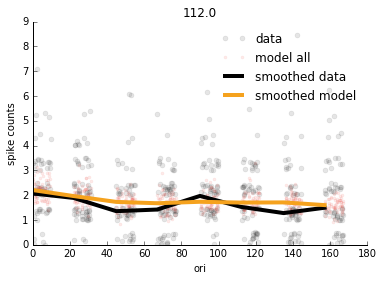

84 spikes.9100
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.540657307078
...runnning cv-fold 2 of 2
pseudo_R2:  0.52529390738
pseudo_R2_cv: 0.532976 (+/- 0.005432)
------------------------------------------------------------



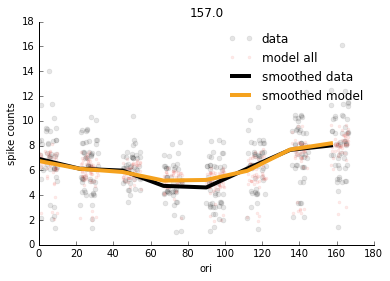

85 spikes.9200
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0174573646181
...runnning cv-fold 2 of 2
pseudo_R2:  0.167453721842
pseudo_R2_cv: 0.092456 (+/- 0.053032)
------------------------------------------------------------



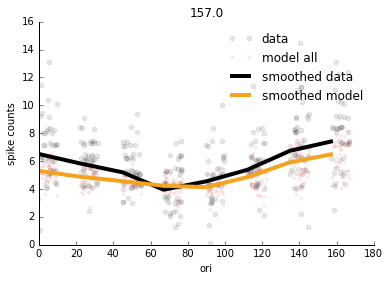

86 spikes.9200
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.0778869429713
...runnning cv-fold 2 of 3
pseudo_R2:  0.294296417524
...runnning cv-fold 3 of 3
pseudo_R2:  0.241126546904
pseudo_R2_cv: 0.152512 (+/- 0.094891)
------------------------------------------------------------



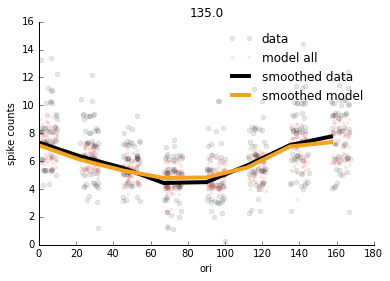

87 spikes.9200
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.513303666841
...runnning cv-fold 2 of 2
pseudo_R2:  0.469968423918
pseudo_R2_cv: 0.491636 (+/- 0.015321)
------------------------------------------------------------



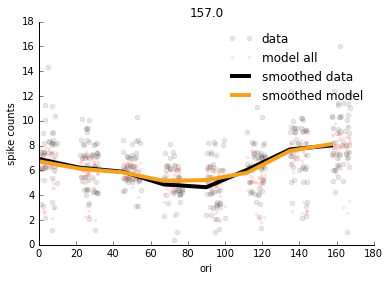

88 spikes.9600
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.11100842874
...runnning cv-fold 2 of 2
pseudo_R2:  0.857147415918
pseudo_R2_cv: 0.484078 (+/- 0.263800)
------------------------------------------------------------



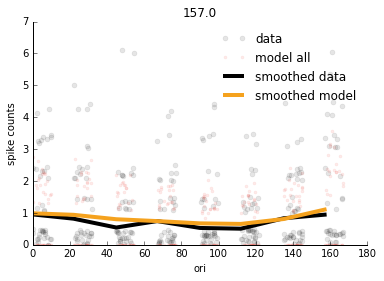

89 spikes.9600
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.845539695865
...runnning cv-fold 2 of 2
pseudo_R2:  0.007423546813
pseudo_R2_cv: 0.426482 (+/- 0.296319)
------------------------------------------------------------



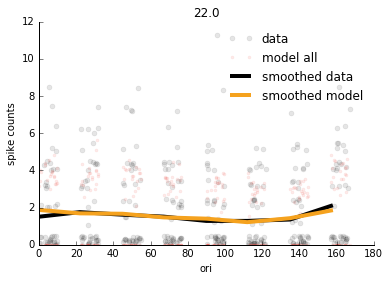

In [6]:
df_fits_art_orientation_all = pd.DataFrame(columns=['art_orientation_model'])

Models_art = dict()
#Models_art['hue'] = dict()
#Models_art['hue']['covariates'] = ['predictors.hue']

Models_art['all'] = dict()
Models_art['all']['covariates'] = ['predictors.ori', 
                                   'predictors.col', 
                                   'predictors.row', 
                                   'predictors.ori_prev',
                                   'predictors.stim_dur', 
                                   'predictors.off_to_onset_times']

# Define a keras a model
input_dim = len(Models_art['all']['covariates'])
hidden_dim = 100
keras_model = V4.keras_GLM(input_dim, hidden_dim)

for neuron_id, neuron_name in enumerate(df_neurons['name']):
    
    print neuron_id, neuron_name
    
    # Extract session numbers
    art_sessions_of_interest = df_neurons.loc[neuron_id]['art_sessions']
    
    # Grab relevant data
    df_sessions_of_interest = df.loc[df['session.number'].isin(art_sessions_of_interest)]
    
    # Labels and number of folds for stratified CV
    labels = df_sessions_of_interest['session.number']
    n_cv = np.size(np.unique(art_sessions_of_interest))
    
    # Get spike counts
    Y = df_sessions_of_interest[neuron_name].values
    
    # If they are nan, skip the neuron
    if(np.any(np.isnan(Y))):
        temp = dict()
        temp['ori'] = []
        temp['spike_counts'] = []
        temp['predicted_spike_counts'] = []
        temp['pseudo_R2'] = []
        df_fits_art_orientation_all.loc[neuron_id] = [temp]
        continue
        
    # Loop through models
    for model_number, model in enumerate(Models_art):
        print 'running model %d of %d: %s' % (model_number+1, len(Models_art), model)
        
        # Get covariates
        X = df_sessions_of_interest[Models_art[model]['covariates']].values        
        
        # Fit models
        Yt_hat, pseudo_R2 = V4.fit_cv(X, Y,
                                      stratify_by_labels=labels,
                                      n_cv=n_cv,
                                      algorithm='XGB_poisson',
                                      model=keras_model,
                                      batch_size=32,
                                      epochs=50,
                                      verbose=2)
        
        Models_art[model]['Yt_hat'], Models_art[model]['pseudo_R2'] = Yt_hat, pseudo_R2    
        print ''

        x_data = df_sessions_of_interest['predictors.ori'].values
        y_data = Y
        xlabel = 'ori'
        V4.plot_xy(x_data=x_data, y_data=y_data,
                   y_model=Models_art[model]['Yt_hat'],
                   lowess_frac=0.3, xlabel=xlabel, model_name=model, 
                   x_jitter_level=10., y_jitter_level=0.5)
        plt.title((X[np.argmax(Models_art[model]['Yt_hat'])])[0])
        #plt.ylim([0,4])
        plt.show()
        temp = dict()
        temp['ori'] = df_sessions_of_interest['predictors.ori'].values
        temp['spike_counts'] = Y
        temp['predicted_spike_counts'] = Yt_hat   
        temp['pseudo_R2'] = pseudo_R2
        
    df_fits_art_orientation_all.loc[neuron_id] = [temp]

In [8]:
model

'all'

In [7]:
len(df_fits_art_orientation_all)

90

### Visualize example neuron

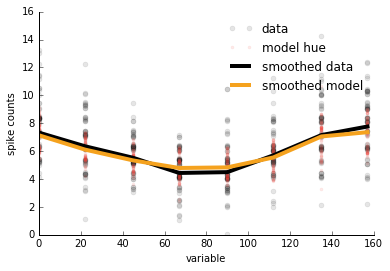

In [8]:
neuron_id = 86
V4.plot_xy(x_data=df_fits_art_orientation_all.loc[neuron_id]['art_orientation_model']['ori'], 
           y_data=df_fits_art_orientation_all.loc[neuron_id]['art_orientation_model']['spike_counts'], 
           y_model=df_fits_art_orientation_all.loc[neuron_id]['art_orientation_model']['predicted_spike_counts'])

## B. Natural and synthetic tuning curves [hue histograms and VGG16]

### Read session files and get predictors and spike counts into a useful data frame

In [6]:
nat_sessions =dict()
for i, f in enumerate(np.sort(np.unique(data_M3['Natural']))):
    nat_sessions[i] = f
nat_sessions

{0: u'Ro150125_s83a_FreeViewPic_0004',
 1: u'Ro150125_s83a_FreeViewPic_0005',
 2: u'Ro150127_s84a_FreeViewPic_0001',
 3: u'Ro150128_s85a_FreeViewPic_0001',
 4: u'Ro150129_s86a_FreeViewPic_0001',
 5: u'Ro150129_s86a_FreeViewPic_0005',
 6: u'Ro150210_s87a_FreeViewPic_manyimage_0004',
 7: u'Ro150211_s88a_FreeViewPic_manyimages_0004',
 8: u'Ro150211_s88a_FreeViewPic_manyimages_0005',
 9: u'Ro150212_289a_FreeViewPic_manyimages_0004',
 10: u'Ro150213_s90a_FreeViewPic_0004',
 11: u'Ro150216_s91a_FreeViewPic_0004',
 12: u'Ro150216_s91a_FreeViewPic_0005',
 13: u'Ro150217_s92a_FreeViewPic_0004',
 14: u'Ro150217_s92a_FreeViewPic_0005'}

### Concatenate across sessions

In [7]:
dfs = list()
for s in nat_sessions:
    fname = h5path + nat_sessions[s] + '_nev.h5'
    df0 = V4.nat_file_to_df(session_number=s, 
                            session_name=fname,
                            in_screen_radius=200,
                            neurons=None, 
                            window=[50, 300])
    dfs.append(df0)
    print nat_sessions[s], len(df0), "fixations", len(df0.filter(regex="spikes").columns), "neurons"

Ro150125_s83a_FreeViewPic_0004 3243 fixations 53 neurons


KeyboardInterrupt: 

In [ ]:
# Concatenate
nat_df = pd.concat( (dfs))

# Reorder
reordered = list()
reordered.extend(tuple([c for c in nat_df.columns if 'predictors.' in c]))
reordered.extend(tuple([c for c in nat_df.columns if 'im.' in c]))
reordered.extend(tuple([c for c in nat_df.columns if 'filters.' in c]))
reordered.extend(tuple(np.sort([c for c in nat_df.columns if 'spikes.' in c])))
reordered.extend(tuple([c for c in nat_df.columns if 'session.' in c]))
nat_df = nat_df[reordered]
nat_df.reset_index(drop=True, inplace=True)
print len(nat_df.filter(regex='spikes').columns), "neurons across sessions"
nat_df.head()

In [48]:
nat_df.to_pickle('../02-preprocessed_data/merged_nat_data_across_sessions')

### Read in precomputed data frame

In [5]:
nat_df = pd.read_pickle('../02-preprocessed_data/M3/merged_nat_data_across_sessions')

### Helper functions [eventually move to utils]

In [44]:
from tqdm import tqdm
def get_nat_features(df=df, 
                     reject_conditions=None,
                     stimpath=None,
                     radius=200, RF_block=14,
                     n_histogram_bins=16,
                     model_list=['histogram'],
                     non_image_features_list=None):
    """
    This is the master function to extract image features from
    a data frame that has image name and image path
    """
    image_features = list()      # image features
    non_image_features = list()  # non-image features
    accepted_indices = list()
    
    if 'vgg' in model_list:
        # Instantiate vgg models
        vgg_model_l8 = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
                                            weights_file='../02-preprocessed_data/vgg16_weights.h5',
                                            n_pops=0)
        vgg_model_l7 = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
                                            weights_file='../02-preprocessed_data/vgg16_weights.h5',
                                            n_pops=1)
        vgg_model_l6 = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
                                            weights_file='../02-preprocessed_data/vgg16_weights.h5',
                                            n_pops=3)
        vgg_model_l5 = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
                                            weights_file='../02-preprocessed_data/vgg16_weights.h5',
                                            n_pops=5)
    # Loop through the data frame
    for fx in tqdm(df.index):
        
        # Check for reject conditions
        select = list()
        for k in reject_conditions.keys():
            select.append(df.loc[fx][k] == reject_conditions[k])
        select = np.all(select)
        
        prev_impath, prev_imname = None, None
        if select == True:
            # Open image file
            impath = df.loc[fx]['im.path']
            imname = df.loc[fx]['im.name']
            if(impath != prev_impath or imname != prev_imname):
                I = V4.get_image(stimpath=stimpath, impath=impath, imname=imname)
            prev_impath, prev_imname = impath, imname
            
            # Check for missing image file
            if I is None: 
                continue
            
            # Cut relevant fixation
            r, c = df.loc[fx]['predictors.row'], df.loc[fx]['predictors.col']
            I_fix = I[r-radius:r+radius, c-radius:c+radius, :]
            
            # Grid image into blocks
            Block = V4.grid_image(I_fix, [4, 4])
            
            this_image_feature = dict()
            # Extract feature for desired image
            
            if 'histogram' in model_list:
                hue_image = V4.get_hue_image(Block[RF_block]) 
                this_image_feature['hue.histogram'] = \
                   list(V4.get_hue_histogram(hue_image, n_bins=n_histogram_bins))
                this_image_feature['hue.mean'] = circmean(hue_image)
                this_image_feature = pd.Series(this_image_feature)
                
            if 'vgg' in model_list:
                # Prepare the image for vgg input               
                I_fix_for_vgg = V4.prepare_image_for_vgg(I_fix[::-1])
                
                # Compute feed forward pass
                this_image_feature['vgg.l8'] = np.squeeze(vgg_model_l8.predict(I_fix_for_vgg))
                this_image_feature['vgg.l7'] = np.squeeze(vgg_model_l7.predict(I_fix_for_vgg))
                this_image_feature['vgg.l6'] = np.squeeze(vgg_model_l6.predict(I_fix_for_vgg))
                this_image_feature['vgg.l5'] = np.squeeze(vgg_model_l5.predict(I_fix_for_vgg))
              
            # Accumulate non-image features
            this_non_image_feature = df.loc[fx][non_image_features_list]
            
            # Collect features in a list
            image_features.append(this_image_feature)
            non_image_features.append(this_non_image_feature)
            accepted_indices.append(fx)
            
    # Put everything into a data frame
    nat_features = pd.DataFrame({'image_features': image_features, 
                                 'non_image_features': non_image_features,
                                 'accepted_indices': accepted_indices})
    return nat_features

In [7]:
def nat_features_to_array(nat_features_df, image_feature='hue.histogram'):
    """
    Take a data frame containing features of interest
    and convert to array for model fitting
    """
    n_samples = len(nat_features_df)
    
    # Image features
    n_features = len(nat_features_df['image_features'][nat_features_df.index[0]][image_feature])
    image_features_array = np.zeros((n_samples, n_features))
    image_features_list = [nat_features_df['image_features'][k][image_feature] \
                           for k in nat_features_df.index]
    for k in range(n_samples):
        image_features_array[k, :] = image_features_list[k]
    
    # Non-image features
    n_features = np.shape(nat_features_df['non_image_features'][nat_features_df.index[0]].values)[0]
    non_image_features_array = np.zeros((n_samples, n_features))
    non_image_features_list = [nat_features_df['non_image_features'][k].values \
                           for k in nat_features_df.index]
    for k in range(n_samples):
        non_image_features_array[k, :] = non_image_features_list[k]

    # Concatenate
    return np.concatenate((image_features_array, 
                           non_image_features_array), 
                          axis=1)

### Extract features

In [46]:
# Setup some conditions according to which trials are rejected
reject_conditions = dict()
reject_conditions['filters.in_screen_radius'] = True 
reject_conditions['filters.badfix'] = False

non_image_features_list = ['predictors.col',
                           'predictors.row',
                           'predictors.trial',
                           'predictors.fixation', 
                           'predictors.out_sac_blink',
                           'predictors.in_sac_dur',
                           'predictors.fix_duration',
                           'predictors.prev_fix_duration',
                           'predictors.drift', 
                           'predictors.out_sac_dur',
                           'predictors.next_fix_duration']

# Compute predictive features for X matrix
nat_features = get_nat_features(df=nat_df,
                                reject_conditions=reject_conditions,
                                stimpath='../V4pydata',
                                radius=200, RF_block=14,
                                n_histogram_bins=16,
                                model_list=['histogram', 'vgg'],
                                non_image_features_list=non_image_features_list)

100%|██████████| 77691/77691 [58:14<00:00, 23.56it/s]


In [52]:
#np.shape(nat_features['image_features'][0]['vgg.l5'])
len(nat_features)

32994

In [7]:
nat_features.to_pickle('../02-preprocessed_data/precomputed_nat_features')

NameError: name 'nat_features' is not defined

### Read in precomputed features

In [6]:
nat_features = pd.read_pickle('../02-preprocessed_data/M3/precomputed_nat_features')

In [11]:
# Define a keras a model
hidden_dim = 100

### Instantiate vgg models

In [12]:
# vgg_model = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
#                                  weights_file='../02-preprocessed_data/vgg16_weights.h5',
#                                  n_pops=0)
# #vgg_model = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
# #                                 weights_file='../02-preprocessed_data/vgg16_weights.h5',
# #                                 n_pops=1)
# #vgg_model = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
# #                                 weights_file='../02-preprocessed_data/vgg16_weights.h5',
# #                                 n_pops=3)
# #vgg_model = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
# #                                 weights_file='../02-preprocessed_data/vgg16_weights.h5',
# #                                 n_pops=5)


### Loop through neurons and fit models

In [11]:
df_models = pd.DataFrame(columns=['vggl5_model'])
image_feature = 'vgg.l6'

# if image_feature == 'vgg.l8':
#     vgg_model= V4.vgg_transfer_ari(n_pops=0)
# elif image_feature == 'vgg.l7':
#     vgg_model= V4.vgg_transfer_ari(n_pops=1)
# elif image_feature == 'vgg.l6':
#     vgg_model= V4.vgg_transfer_ari(n_pops=2)
# elif image_feature == 'vgg.l5':
#     vgg_model= V4.vgg_transfer_ari(n_pops=3)

# Loop through df_neurons
for neuron_id, neuron_name in enumerate(df_neurons['name']):

    neuron_name = df_neurons.loc[neuron_id]['name']
    print neuron_name
    
    # Extract session numbers
    nat_sessions_of_interest = df_neurons.loc[neuron_id]['nat_sessions']
    
    # Grab relevant data
    nat_df_sessions_of_interest = nat_df.loc[nat_df['session.number'].isin(nat_sessions_of_interest) & \
                                             nat_df.index.isin(nat_features['accepted_indices'])]
    
    # Labels and number of folds for stratified CV
    labels = nat_df_sessions_of_interest['session.number']
    n_cv = np.size(np.unique(nat_sessions_of_interest))
    labels = [] if n_cv == 1 else labels
    n_cv = 10 if n_cv == 1 else n_cv
        
    # Get spike counts
    Y = nat_df_sessions_of_interest[neuron_name].values
    
    #-----------------
    # Get covariates
    #-----------------
    # Select a df of interest
    indices_of_interest = np.array(nat_df_sessions_of_interest.index)
    nat_features_of_interest = \
        nat_features.loc[nat_features['accepted_indices'].isin(indices_of_interest)]
    
    # Convert everything to array
    n_samples = len(nat_features_of_interest)
    
    # Image features
    n_features = len(nat_features_of_interest['image_features'][nat_features_of_interest.index[0]][image_feature])
    image_features_array = np.zeros((n_samples, n_features))
    image_features_list = [nat_features_of_interest['image_features'][k][image_feature] \
                           for k in nat_features_of_interest.index]
    for k in range(n_samples):
        image_features_array[k, :] = image_features_list[k]
    
    # Non-image features
    n_features = np.shape(nat_features_of_interest['non_image_features'][nat_features_of_interest.index[0]].values)[0]
    non_image_features_array = np.zeros((n_samples, n_features))
    non_image_features_list = [nat_features_of_interest['non_image_features'][k].values \
                           for k in nat_features_of_interest.index]
    for k in range(n_samples):
        non_image_features_array[k, :] = non_image_features_list[k]

    #-------------
    # Fit models
    #-------------
    hidden_dim = 10
    keras_joint_model = V4.keras_GLM(4107, hidden_dim)
    keras_image_model = V4.keras_GLM(4096, hidden_dim)
    #keras_joint_model = V4.keras_GLM(1011, hidden_dim, learning_rate=0.01)
    #keras_image_model = V4.keras_GLM(1000, hidden_dim, learning_rate=0.01)
#     keras_joint_model = V4.keras_GLM(25099, hidden_dim)
#     keras_image_model = V4.keras_GLM(25088, hidden_dim)
    # ------------
    # Joint Model
    # ------------
    joint_model = dict()
    # Concatenate
    X = np.concatenate((image_features_array, 
                        non_image_features_array), 
                        axis=1)
    
    k_joint_model = V4.fit(X, Y, algorithm='GLM_poisson',
                   model=keras_joint_model,
                   batch_size=128, epochs=50)    
    #k_joint_model.save_weights('../02-preprocessed_data/fit_models/'+str(neuron_id)+'_'+neuron_name+'_l5_joint')
    
    # Cross-validated predictions and scores
    Yt_hat, joint_model['pseudo_R2'] = V4.fit_cv(X, Y,
                                                 stratify_by_labels=labels,
                                                 n_cv=n_cv,
                                                 algorithm='GLM_poisson',
                                                 model=keras_joint_model,
                                                 batch_size=128,
                                                 epochs=50,
                                                 verbose=2)
    # ------------
    # Image Model
    # ------------
    image_model = dict()
    # Concatenate
    X = image_features_array
    
    k_image_model = V4.fit(X, Y, algorithm='GLM_poisson',
                   model=keras_image_model,
                   batch_size=128, epochs=50)    
    #k_image_model.save_weights('../02-preprocessed_data/fit_models/'+str(neuron_id)+'_'+neuron_name+'_l5_image')
    
    # Cross-validated predictions and scores
    Yt_hat, image_model['pseudo_R2'] = V4.fit_cv(X, Y,
                                                 stratify_by_labels=labels,
                                                 n_cv=n_cv,
                                                 algorithm='GLM_poisson',
                                                 model=keras_image_model,
                                                 batch_size=128,
                                                 epochs=50,
                                                 verbose=2)
    
    print ''
    
    # Accumulate model predictions
    temp = dict()
    temp['joint_model'] = joint_model
    temp['image_model'] = image_model
    df_models.loc[neuron_id] = [temp]
    

spikes.0101
------------------------------------------------------------
...runnning cv-fold 1 of 10
pseudo_R2:  -0.561581580797
...runnning cv-fold 2 of 10
pseudo_R2:  0.109370504961
...runnning cv-fold 3 of 10
pseudo_R2:  0.111499846435
...runnning cv-fold 4 of 10
pseudo_R2:  0.189730768242
...runnning cv-fold 5 of 10
pseudo_R2:  0.482248244631
...runnning cv-fold 6 of 10
pseudo_R2:  0.472189963876
...runnning cv-fold 7 of 10
pseudo_R2:  0.406141041291
...runnning cv-fold 8 of 10
pseudo_R2:  0.435800454281
...runnning cv-fold 9 of 10
pseudo_R2:  0.66855091478
...runnning cv-fold 10 of 10
pseudo_R2:  0.361777595005
pseudo_R2_cv: 0.267573 (+/- 0.102375)
------------------------------------------------------------
------------------------------------------------------------
...runnning cv-fold 1 of 10
pseudo_R2:  -1.05640254134
...runnning cv-fold 2 of 10
pseudo_R2:  0.117476550761
...runnning cv-fold 3 of 10
pseudo_R2:  0.1578682422
...runnning cv-fold 4 of 10
pseudo_R2:  -0.0425853589

KeyboardInterrupt: 

In [34]:
df_models

vggl5_model
0   {u'joint_model': {u'pseudo_R2': [-0.7506680162...
1   {u'joint_model': {u'pseudo_R2': [0.98007654002...
2   {u'joint_model': {u'pseudo_R2': [-0.6036440721...
3   {u'joint_model': {u'pseudo_R2': [0.34951682797...
4   {u'joint_model': {u'pseudo_R2': [0.59114579379...
5   {u'joint_model': {u'pseudo_R2': [0.50427074492...
6   {u'joint_model': {u'pseudo_R2': [0.00148783164...
7   {u'joint_model': {u'pseudo_R2': [0.77196868010...
8   {u'joint_model': {u'pseudo_R2': [-1.5239609347...
9   {u'joint_model': {u'pseudo_R2': [-0.1247523706...
10  {u'joint_model': {u'pseudo_R2': [-9.4610911247...
11  {u'joint_model': {u'pseudo_R2': [0.78868419175...
12  {u'joint_model': {u'pseudo_R2': [0.57556465983...
13  {u'joint_model': {u'pseudo_R2': [0.37722601293...
14  {u'joint_model': {u'pseudo_R2': [-10.467604831...
15  {u'joint_model': {u'pseudo_R2': [0.05353663636...
16  {u'joint_model': {u'pseudo_R2': [0.83537480018...
17  {u'joint_model': {u'pseudo_R2': [0.43196592489...
18  {u'joint_model': {u'pseudo_R2': [0.27954020331...
19  {u'joint_model': {u'pseudo_R2': [0.30215429291...
20  {u'joint_model': {u'pseudo_R2': [-0.5258640132...
21  {u'joint_model': {u'pseudo_R2': [0.74676368669...
22  {u'joint_model': {u'pseudo_R2': [0.58471357245...
23  {u'joint_model': {u'pseudo_R2': [0.06634909017...
24  {u'joint_model': {u'pseudo_R2': [-0.2895689288...
25  {u'joint_model': {u'pseudo_R2': [-2.8380442123...
26  {u'joint_model': {u'pseudo_R2': [0.27239255437...
27  {u'joint_model': {u'pseudo_R2': [0.78144509317...
28  {u'joint_model': {u'pseudo_R2': [0.43761396140...
29  {u'joint_model': {u'pseudo_R2': [-0.2929711569...
..                                                ...
60  {u'joint_model': {u'pseudo_R2': [0.43048151194...
61  {u'joint_model': {u'pseudo_R2': [0.90144962733...
62  {u'joint_model': {u'pseudo_R2': [-1.3500572452...
63  {u'joint_model': {u'pseudo_R2': [0.56069320975...
64  {u'joint_model': {u'pseudo_R2': [0.63449294448...
65  {u'joint_model': {u'pseudo_R2': [-1.3991459306...
66  {u'joint_model': {u'pseudo_R2': [0.43673287615...
67  {u'joint_model': {u'pseudo_R2': [0.89763110679...
68  {u'joint_model': {u'pseudo_R2': [0.90892044428...
69  {u'joint_model': {u'pseudo_R2': [0.91182891283...
70  {u'joint_model': {u'pseudo_R2': [0.52975013503...
71  {u'joint_model': {u'pseudo_R2': [0.83596721063...
72  {u'joint_model': {u'pseudo_R2': [0.34673087888...
73  {u'joint_model': {u'pseudo_R2': [-0.9759314732...
74  {u'joint_model': {u'pseudo_R2': [0.51355256761...
75  {u'joint_model': {u'pseudo_R2': [0.24041686049...
76  {u'joint_model': {u'pseudo_R2': [0.63693055170...
77  {u'joint_model': {u'pseudo_R2': [0.05091321868...
78  {u'joint_model': {u'pseudo_R2': [-1.9585944099...
79  {u'joint_model': {u'pseudo_R2': [-0.2281213978...
80  {u'joint_model': {u'pseudo_R2': [0.71591284541...
81  {u'joint_model': {u'pseudo_R2': [-2.3296487728...
82  {u'joint_model': {u'pseudo_R2': [0.15526629234...
83  {u'joint_model': {u'pseudo_R2': [0.44220851312...
84  {u'joint_model': {u'pseudo_R2': [0.89335665098...
85  {u'joint_model': {u'pseudo_R2': [0.70189383415...
86  {u'joint_model': {u'pseudo_R2': [0.71426559661...
87  {u'joint_model': {u'pseudo_R2': [0.89990660157...
88  {u'joint_model': {u'pseudo_R2': [0.45278439294...
89  {u'joint_model': {u'pseudo_R2': [0.71402696063...

[90 rows x 1 columns]

### Design artificial stimuli and compute convnet codebooks

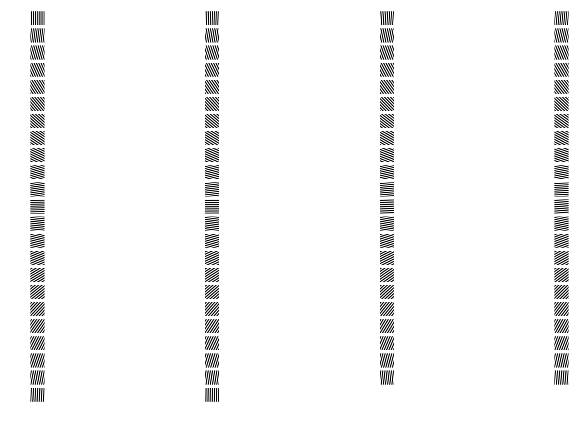

In [35]:
def make_sine_grating(n_pixels=224, theta=0, spatial_freq=0.03, phase=0):
    
    # Design the grating
    [x, y] = np.meshgrid(np.arange(n_pixels), np.arange(n_pixels))
    theta = 180. - theta
    x_theta = x * np.cos(theta / 180. * np.pi) + y * np.sin(theta / 180. * np.pi)
    y_theta = -x * np.sin(theta / 180. * np.pi) + y * np.cos(theta / 180. * np.pi)
    grating = (1. + np.cos(2 * np.pi * spatial_freq * x_theta + phase / 180. * np.pi))/ 2.
    
    # Make it into an image
    G = np.zeros((n_pixels, n_pixels, 3))
    G[:, :, 0] = grating * 255.
    G[:, :, 1] = grating * 255.
    G[:, :, 2] = grating * 255.    
    return np.uint8(G)


#angles = [0.,   22.,   45.,   67.,   90.,  112.,  135.,  157.]
angles = np.linspace(0., 179.0, num=90.)
phases = 0. * np.random.rand(90)
plt.figure(figsize=(12,7))

# Extract vgg features for oriented gratings
Xgrating_vgg = list()
for a, ang in enumerate(angles):
    G = make_sine_grating(theta=angles[a], phase=phases[a])
    G_for_vgg = V4.prepare_image_for_vgg(G)
    Xgrating_vgg.append(np.squeeze(vgg_model.predict(G_for_vgg)))
    
    plt.subplot(23, 4, a + 1)
    plt.imshow(G, interpolation='none')
    plt.axis('off')
plt.show()
Xgrating_vgg = np.array(Xgrating_vgg)

### Make predictions on orientation stimuli

In [36]:
df_predictions = pd.DataFrame(columns=['vggl5_orientation_prediction'])

# Loop through df_neurons
for neuron_id, neuron_name in enumerate(df_neurons['name']):
#for neuron_id in [12, 13, 14, 34, 38, 39, 40, 41, 72, 76, 77, 84, 85, 86, 87]:
#for neuron_id in [86]:
    neuron_name = df_neurons.loc[neuron_id]['name']
    print neuron_name
    
    # Extract session numbers
    nat_sessions_of_interest = df_neurons.loc[neuron_id]['nat_sessions']
    
    # Grab relevant data
    nat_df_sessions_of_interest = nat_df.loc[nat_df['session.number'].isin(nat_sessions_of_interest) & \
                                             nat_df.index.isin(nat_features['accepted_indices'])]
    
    #-----------------
    # Get covariates
    #-----------------
    # Select a df of interest
    indices_of_interest = np.array(nat_df_sessions_of_interest.index)
    nat_features_of_interest = \
        nat_features.loc[nat_features['accepted_indices'].isin(indices_of_interest)]
    
    # Convert everything to array
    n_samples = len(nat_features_of_interest)
        
    # Non-image features
    n_features = np.shape(nat_features_of_interest['non_image_features'][nat_features_of_interest.index[0]].values)[0]
    non_image_features_array = np.zeros((n_samples, n_features))
    non_image_features_list = [nat_features_of_interest['non_image_features'][k].values \
                           for k in nat_features_of_interest.index]
    for k in range(n_samples):
        non_image_features_array[k, :] = non_image_features_list[k]

    #----------------------------
    # Predict on grating stimuli
    #----------------------------
    
    #-------------
    # Joint model
    #-------------
    #model = df_models.loc[neuron_id]['vggl6_model']['joint_model']['model']
    keras_joint_model.load_weights('../02-preprocessed_data/fit_models/'+str(neuron_id)+'_'+neuron_name+'_l5_joint')
    random_resample = np.random.randint(0, n_samples, Xgrating_vgg.shape[0])
    Xgrating_augment = np.concatenate((Xgrating_vgg, 
                                      non_image_features_array[random_resample, :]), 
                                      axis=1)
    #Ygrating_hat_joint = model.predict(xgb.DMatrix(Xgrating_augment))
    Ygrating_hat_joint = keras_joint_model.predict(Xgrating_augment)
    
    #-------------
    # Image model
    #-------------
    #k_image_model = df_models.loc[neuron_id]['vggl6_model']['image_model']['model']
    keras_image_model.load_weights('../02-preprocessed_data/fit_models/'+str(neuron_id)+'_'+neuron_name+'_l5_image')
    #Ygrating_hat_image = model.predict(xgb.DMatrix(Xgrating_vgg))
    Ygrating_hat_image = keras_image_model.predict(Xgrating_vgg)
    print ''
    
    # Accumulate everything for later
    temp = dict()
    temp['ori'] = angles
    temp['joint_predicted_spike_counts'] = np.squeeze(Ygrating_hat_joint)
    temp['image_predicted_spike_counts'] = np.squeeze(Ygrating_hat_image)
    df_predictions.loc[neuron_id] = [temp]
    

spikes.0101

spikes.0301

spikes.0500

spikes.0500

spikes.0600

spikes.0700

spikes.0700

spikes.0700

spikes.0900

spikes.0900

spikes.0900

spikes.1100

spikes.1400

spikes.1400

spikes.1400

spikes.1500

spikes.1500

spikes.1701

spikes.2101

spikes.2501

spikes.2801

spikes.2901

spikes.2901

spikes.3201

spikes.3201

spikes.3401

spikes.3401

spikes.3601

spikes.3701

spikes.3701

spikes.3701

spikes.3801

spikes.3801

spikes.3901

spikes.3901

spikes.4301

spikes.4301

spikes.4401

spikes.4501

spikes.4501

spikes.4501

spikes.4501

spikes.4701

spikes.4701

spikes.4901

spikes.4901

spikes.5101

spikes.5101

spikes.5201

spikes.5201

spikes.5201

spikes.5201

spikes.5301

spikes.5301

spikes.5401

spikes.5401

spikes.5401

spikes.5501

spikes.5501

spikes.5601

spikes.5601

spikes.5601

spikes.5801

spikes.5801

spikes.6101

spikes.6201

spikes.6400

spikes.6400

spikes.7300

spikes.7500

spikes.7800

spikes.8000

spikes.8100

spikes.8300

spikes.8300

spikes.8400

spikes.8400


### Read in hue stimuli and compute convnet codebooks

In [73]:
Xplain_vgg = list()
stimpath = '../V4pydata'

angles = np.arange(0, 360)

for stim_id in angles:
    imname = '/stimuli/M3/Hues/img%03d.jpg' % stim_id
    filename = stimpath + imname
    I = cv2.imread(filename)
    I_for_vgg = V4.prepare_image_for_vgg(I)
    Xplain_vgg.append(np.squeeze(vgg_model.predict(I_for_vgg)))
Xplain_vgg = np.array(Xplain_vgg)

In [74]:
Xplain_vgg.shape

(360, 1000)

### Make predictions on hue stimuli

In [75]:
df_predictions = pd.DataFrame(columns=['vggl8_hue_prediction'])

# Loop through df_neurons
for neuron_id, neuron_name in enumerate(df_neurons['name']):
#for neuron_id in [12, 13, 14, 34, 38, 39, 40, 41, 72, 76, 77, 84, 85, 86, 87]:
#for neuron_id in [86]:
    neuron_name = df_neurons.loc[neuron_id]['name']
    print neuron_name
    
    # Extract session numbers
    nat_sessions_of_interest = df_neurons.loc[neuron_id]['nat_sessions']
    
    # Grab relevant data
    nat_df_sessions_of_interest = nat_df.loc[nat_df['session.number'].isin(nat_sessions_of_interest) & \
                                             nat_df.index.isin(nat_features['accepted_indices'])]
    
    #-----------------
    # Get covariates
    #-----------------
    # Select a df of interest
    indices_of_interest = np.array(nat_df_sessions_of_interest.index)
    nat_features_of_interest = \
        nat_features.loc[nat_features['accepted_indices'].isin(indices_of_interest)]
    
    # Convert everything to array
    n_samples = len(nat_features_of_interest)
        
    # Non-image features
    n_features = np.shape(nat_features_of_interest['non_image_features'][nat_features_of_interest.index[0]].values)[0]
    non_image_features_array = np.zeros((n_samples, n_features))
    non_image_features_list = [nat_features_of_interest['non_image_features'][k].values \
                           for k in nat_features_of_interest.index]
    for k in range(n_samples):
        non_image_features_array[k, :] = non_image_features_list[k]

    #----------------------------
    # Predict on hue stimuli
    #----------------------------
    
    #-------------
    # Joint model
    #-------------
    #model = df_models.loc[neuron_id]['vggl6_model']['joint_model']['model']
    keras_joint_model.load_weights('../02-preprocessed_data/fit_models/'+str(neuron_id)+'_'+neuron_name+'_l8_joint')
    random_resample = np.random.randint(0, n_samples, Xplain_vgg.shape[0])
    Xplain_augment = np.concatenate((Xplain_vgg, 
                                      non_image_features_array[random_resample, :]), 
                                      axis=1)
    #Yplain_hat_joint = model.predict(xgb.DMatrix(Xplain_augment))
    Yplain_hat_joint = keras_joint_model.predict(Xplain_augment)
    
    #-------------
    # Image model
    #-------------
    #k_image_model = df_models.loc[neuron_id]['vggl6_model']['image_model']['model']
    keras_image_model.load_weights('../02-preprocessed_data/fit_models/'+str(neuron_id)+'_'+neuron_name+'_l8_image')
    #Yplain_hat_image = model.predict(xgb.DMatrix(Xplain_vgg))
    Yplain_hat_image = keras_image_model.predict(Xplain_vgg)
    print ''
    
    # Accumulate everything for later
    temp = dict()
    temp['ori'] = angles
    temp['joint_predicted_spike_counts'] = np.squeeze(Yplain_hat_joint)
    temp['image_predicted_spike_counts'] = np.squeeze(Yplain_hat_image)
    df_predictions.loc[neuron_id] = [temp]
    

spikes.0101

spikes.0301

spikes.0500

spikes.0500

spikes.0600

spikes.0700

spikes.0700

spikes.0700

spikes.0900

spikes.0900

spikes.0900

spikes.1100

spikes.1400

spikes.1400

spikes.1400

spikes.1500

spikes.1500

spikes.1701

spikes.2101

spikes.2501

spikes.2801

spikes.2901

spikes.2901

spikes.3201

spikes.3201

spikes.3401

spikes.3401

spikes.3601

spikes.3701

spikes.3701

spikes.3701

spikes.3801

spikes.3801

spikes.3901

spikes.3901

spikes.4301

spikes.4301

spikes.4401

spikes.4501

spikes.4501

spikes.4501

spikes.4501

spikes.4701

spikes.4701

spikes.4901

spikes.4901

spikes.5101

spikes.5101

spikes.5201

spikes.5201

spikes.5201

spikes.5201

spikes.5301

spikes.5301

spikes.5401

spikes.5401

spikes.5401

spikes.5501

spikes.5501

spikes.5601

spikes.5601

spikes.5601

spikes.5801

spikes.5801

spikes.6101

spikes.6201

spikes.6400

spikes.6400

spikes.7300

spikes.7500

spikes.7800

spikes.8000

spikes.8100

spikes.8300

spikes.8300

spikes.8400

spikes.8400


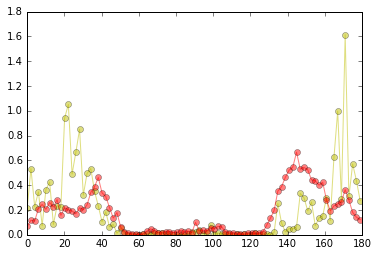

In [43]:
neuron_id = 40
plt.plot(df_predictions.loc[neuron_id]['vggl5_orientation_prediction']['ori'],
         np.squeeze(df_predictions.loc[neuron_id]['vggl5_orientation_prediction']['joint_predicted_spike_counts']),
         'yo-', alpha=0.5)
plt.plot(df_predictions.loc[neuron_id]['vggl5_orientation_prediction']['ori'],
         np.squeeze(df_predictions.loc[neuron_id]['vggl5_orientation_prediction']['image_predicted_spike_counts']),
         'ro-', alpha=0.5)
plt.show()

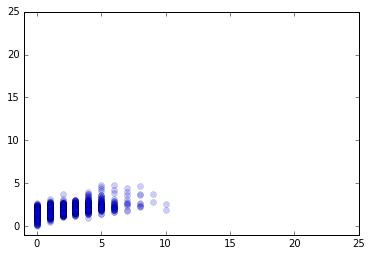

In [22]:
plt.plot(Y, Yt_hat, 'o', alpha=0.2)
plt.axis([-1, 25, -1, 25])
plt.show()

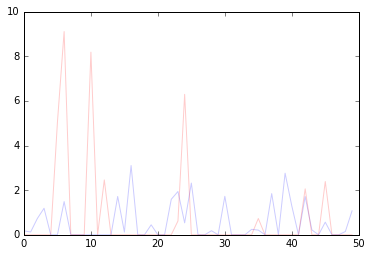

In [23]:
plt.plot(X[10, :50].T, color='b', alpha=0.2)
plt.plot(Xgrating_vgg[40, :50].T, color='r', alpha=0.2)
plt.show()

In [112]:
Y_tmp = k_image_model.predict(X)

In [113]:
Y_grating_tmp = k_image_model.predict(Xgrating_vgg)

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
X_lowd = pca.transform(X)

In [ ]:
#from sklearn.manifold import TSNE
#tsne = TSNE(n_components=2, perplexity=10, verbose=2)
#tsne.fit(X)
#X_lowd = tsne.transform(X)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 7353
[t-SNE] Computed conditional probabilities for sample 2000 / 7353
[t-SNE] Computed conditional probabilities for sample 3000 / 7353
[t-SNE] Computed conditional probabilities for sample 4000 / 7353
[t-SNE] Computed conditional probabilities for sample 5000 / 7353
[t-SNE] Computed conditional probabilities for sample 6000 / 7353
[t-SNE] Computed conditional probabilities for sample 7000 / 7353
[t-SNE] Computed conditional probabilities for sample 7353 / 7353
[t-SNE] Mean sigma: 12.281116


In [1]:
plt.figure()
ax = plt.subplot(111)
ax.scatter(X_lowd[:, 0], X_lowd[:, 1], s=1, c=Y, marker='o', cmap='Greens', edgecolors='face')
plt.show()

#plt.scatter(X_lowd[:, 0], X_lowd[:, 1], color=[1., 0., 0.], alpha=0.5)
#plt.show()

NameError: name 'plt' is not defined

### Accumulate model predictions in a data frame

In [76]:
#df_results_all = df_neurons.merge(df_fits_art_orientation_all, left_index=True, right_index=True)

df_results_all = pd.read_pickle('../02-preprocessed_data/results_all')
#df_results_all = df_results_all.merge(df_models, left_index=True, right_index=True)
df_results_all = df_results_all.merge(df_predictions, left_index=True, right_index=True)
df_results_all.head()

name  art_sessions  \
0  spikes.0101        [2, 3]   
1  spikes.0301        [8, 9]   
2  spikes.0500     [3, 4, 5]   
3  spikes.0500     [4, 5, 6]   
4  spikes.0600  [2, 3, 4, 5]   

                                       art_filenames nat_sessions  \
0  [Ro150127_s84a_huecircle_0003, Ro150128_s85a_h...          [4]   
1  [Ro150211_s88a_huecircle_0003, Ro150212_289a_h...     [11, 12]   
2  [Ro150128_s85a_huecircle_0003, Ro150129_s86a_h...       [5, 6]   
3  [Ro150129_s86a_huecircle_0003, Ro150129_s86a_h...    [6, 7, 8]   
4  [Ro150127_s84a_huecircle_0003, Ro150128_s85a_h...    [4, 5, 6]   

                                       nat_filenames  \
0                   [Ro150129_s86a_FreeViewPic_0001]   
1  [Ro150216_s91a_FreeViewPic_0004, Ro150216_s91a...   
2  [Ro150129_s86a_FreeViewPic_0005, Ro150210_s87a...   
3  [Ro150210_s87a_FreeViewPic_manyimage_0004, Ro1...   
4  [Ro150129_s86a_FreeViewPic_0001, Ro150129_s86a...   

                               art_orientation_model  \
0  {u'pseudo_R2': [0.0724950106919, 0.00377718346...   
1  {u'pseudo_R2': [0.0877322467138, 0.07655893314...   
2  {u'pseudo_R2': [-0.164305084384, 0.18516909914...   
3  {u'pseudo_R2': [-0.280337090405, 0.34500779195...   
4  {u'pseudo_R2': [-0.189620184279, -0.6867100036...   

                                         vggl7_model  \
0  {u'joint_model': {u'pseudo_R2': [-0.2141978938...   
1  {u'joint_model': {u'pseudo_R2': [0.86254361178...   
2  {u'joint_model': {u'pseudo_R2': [0.34827657957...   
3  {u'joint_model': {u'pseudo_R2': [0.30792040254...   
4  {u'joint_model': {u'pseudo_R2': [0.69011502877...   

                        vggl7_orientation_prediction  \
0  {u'image_predicted_spike_counts': [8.95358e-06...   
1  {u'image_predicted_spike_counts': [0.00010816,...   
2  {u'image_predicted_spike_counts': [1.36948, 1....   
3  {u'image_predicted_spike_counts': [0.434884, 0...   
4  {u'image_predicted_spike_counts': [3.18806e-10...   

                                         vggl6_model  \
0  {u'joint_model': {u'pseudo_R2': [-0.4697308976...   
1  {u'joint_model': {u'pseudo_R2': [0.90880513039...   
2  {u'joint_model': {u'pseudo_R2': [0.51152608245...   
3  {u'joint_model': {u'pseudo_R2': [0.46768763223...   
4  {u'joint_model': {u'pseudo_R2': [0.83382402308...   

                        vggl6_orientation_prediction  \
0  {u'image_predicted_spike_counts': [8.88905e-11...   
1  {u'image_predicted_spike_counts': [3.3644e-07,...   
2  {u'image_predicted_spike_counts': [0.0128795, ...   
3  {u'image_predicted_spike_counts': [0.289081, 0...   
4  {u'image_predicted_spike_counts': [2.86144e-14...   

                                         vggl8_model  \
0  {u'joint_model': {u'pseudo_R2': [0.00055362335...   
1  {u'joint_model': {u'pseudo_R2': [0.08335792495...   
2  {u'joint_model': {u'pseudo_R2': [-0.0028350241...   
3  {u'joint_model': {u'pseudo_R2': [-0.0004702767...   
4  {u'joint_model': {u'pseudo_R2': [0.00406069694...   

                        vggl8_orientation_prediction  \
0  {u'image_predicted_spike_counts': [0.0679118, ...   
1  {u'image_predicted_spike_counts': [1.84179, 1....   
2  {u'image_predicted_spike_counts': [4.81843, 5....   
3  {u'image_predicted_spike_counts': [4.72549, 5....   
4  {u'image_predicted_spike_counts': [1.28272, 1....   

                                         vggl5_model  \
0  {u'joint_model': {u'pseudo_R2': [-0.7506680162...   
1  {u'joint_model': {u'pseudo_R2': [0.98007654002...   
2  {u'joint_model': {u'pseudo_R2': [-0.6036440721...   
3  {u'joint_model': {u'pseudo_R2': [0.34951682797...   
4  {u'joint_model': {u'pseudo_R2': [0.59114579379...   

                        vggl5_orientation_prediction  \
0  {u'image_predicted_spike_counts': [9.52494e-12...   
1  {u'image_predicted_spike_counts': [1.43704e-07...   
2  {u'image_predicted_spike_counts': [2.49774e-05...   
3  {u'image_predicted_spike_counts': [0.0191812, ...   
4  {u'image_predicted_spike_counts': [4.3424e-29,...   

                                

### Save everything

In [77]:
df_results_all.to_pickle('../02-preprocessed_data/results_all')

## C. Compare tuning curves

In [46]:
df_results_all = pd.read_pickle('../02-preprocessed_data/results_all')
df_results_all.head()

name  art_sessions  \
0  spikes.0101        [2, 3]   
1  spikes.0301        [8, 9]   
2  spikes.0500     [3, 4, 5]   
3  spikes.0500     [4, 5, 6]   
4  spikes.0600  [2, 3, 4, 5]   

                                       art_filenames nat_sessions  \
0  [Ro150127_s84a_huecircle_0003, Ro150128_s85a_h...          [4]   
1  [Ro150211_s88a_huecircle_0003, Ro150212_289a_h...     [11, 12]   
2  [Ro150128_s85a_huecircle_0003, Ro150129_s86a_h...       [5, 6]   
3  [Ro150129_s86a_huecircle_0003, Ro150129_s86a_h...    [6, 7, 8]   
4  [Ro150127_s84a_huecircle_0003, Ro150128_s85a_h...    [4, 5, 6]   

                                       nat_filenames  \
0                   [Ro150129_s86a_FreeViewPic_0001]   
1  [Ro150216_s91a_FreeViewPic_0004, Ro150216_s91a...   
2  [Ro150129_s86a_FreeViewPic_0005, Ro150210_s87a...   
3  [Ro150210_s87a_FreeViewPic_manyimage_0004, Ro1...   
4  [Ro150129_s86a_FreeViewPic_0001, Ro150129_s86a...   

                               art_orientation_model  \
0  {u'pseudo_R2': [0.0724950106919, 0.00377718346...   
1  {u'pseudo_R2': [0.0877322467138, 0.07655893314...   
2  {u'pseudo_R2': [-0.164305084384, 0.18516909914...   
3  {u'pseudo_R2': [-0.280337090405, 0.34500779195...   
4  {u'pseudo_R2': [-0.189620184279, -0.6867100036...   

                                         vggl7_model  \
0  {u'joint_model': {u'pseudo_R2': [-0.2141978938...   
1  {u'joint_model': {u'pseudo_R2': [0.86254361178...   
2  {u'joint_model': {u'pseudo_R2': [0.34827657957...   
3  {u'joint_model': {u'pseudo_R2': [0.30792040254...   
4  {u'joint_model': {u'pseudo_R2': [0.69011502877...   

                        vggl7_orientation_prediction  \
0  {u'image_predicted_spike_counts': [8.95358e-06...   
1  {u'image_predicted_spike_counts': [0.00010816,...   
2  {u'image_predicted_spike_counts': [1.36948, 1....   
3  {u'image_predicted_spike_counts': [0.434884, 0...   
4  {u'image_predicted_spike_counts': [3.18806e-10...   

                                         vggl6_model  \
0  {u'joint_model': {u'pseudo_R2': [-0.4697308976...   
1  {u'joint_model': {u'pseudo_R2': [0.90880513039...   
2  {u'joint_model': {u'pseudo_R2': [0.51152608245...   
3  {u'joint_model': {u'pseudo_R2': [0.46768763223...   
4  {u'joint_model': {u'pseudo_R2': [0.83382402308...   

                        vggl6_orientation_prediction  \
0  {u'image_predicted_spike_counts': [8.88905e-11...   
1  {u'image_predicted_spike_counts': [3.3644e-07,...   
2  {u'image_predicted_spike_counts': [0.0128795, ...   
3  {u'image_predicted_spike_counts': [0.289081, 0...   
4  {u'image_predicted_spike_counts': [2.86144e-14...   

                                         vggl8_model  \
0  {u'joint_model': {u'pseudo_R2': [0.00055362335...   
1  {u'joint_model': {u'pseudo_R2': [0.08335792495...   
2  {u'joint_model': {u'pseudo_R2': [-0.0028350241...   
3  {u'joint_model': {u'pseudo_R2': [-0.0004702767...   
4  {u'joint_model': {u'pseudo_R2': [0.00406069694...   

                        vggl8_orientation_prediction  \
0  {u'image_predicted_spike_counts': [0.0679118, ...   
1  {u'image_predicted_spike_counts': [1.84179, 1....   
2  {u'image_predicted_spike_counts': [4.81843, 5....   
3  {u'image_predicted_spike_counts': [4.72549, 5....   
4  {u'image_predicted_spike_counts': [1.28272, 1....   

                                         vggl5_model  \
0  {u'joint_model': {u'pseudo_R2': [-0.7506680162...   
1  {u'joint_model': {u'pseudo_R2': [0.98007654002...   
2  {u'joint_model': {u'pseudo_R2': [-0.6036440721...   
3  {u'joint_model': {u'pseudo_R2': [0.34951682797...   
4  {u'joint_model': {u'pseudo_R2': [0.59114579379...   

                        vggl5_orientation_prediction  
0  {u'image_predicted_spike_counts': [9.52494e-12...  
1  {u'image_predicted_spike_counts': [1.43704e-07...  
2  {u'image_predicted_spike_counts': [2.49774e-05...  
3  {u'image_predicted_spike_counts': [0.0191812, ...  
4  {u'image_predicted_spike_counts': [4.3424e-29,...

### Visualize single neuron tuning curves and pseudo-$R^2$s

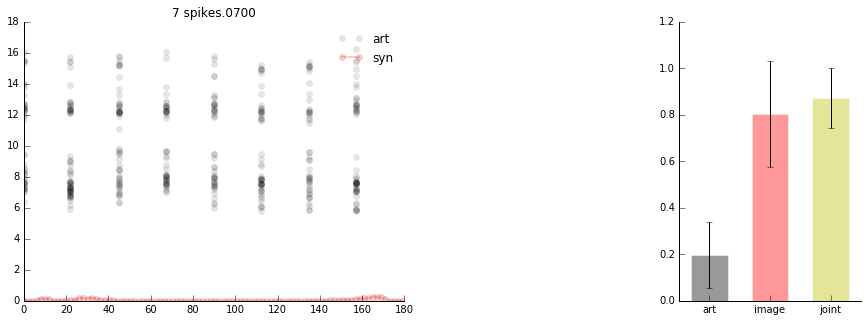

(art, syn): -0.239642


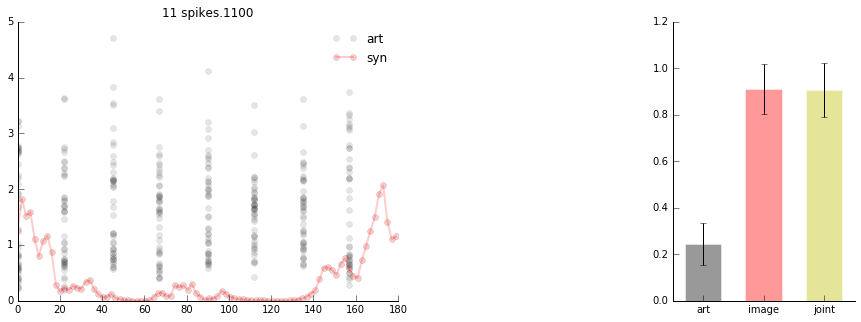

(art, syn): -0.318200


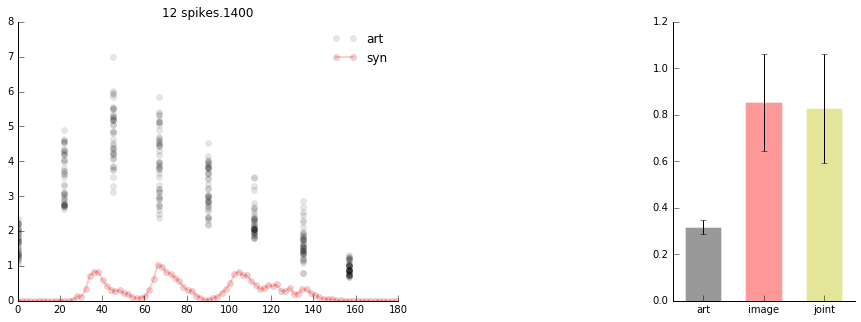

(art, syn): 0.423713


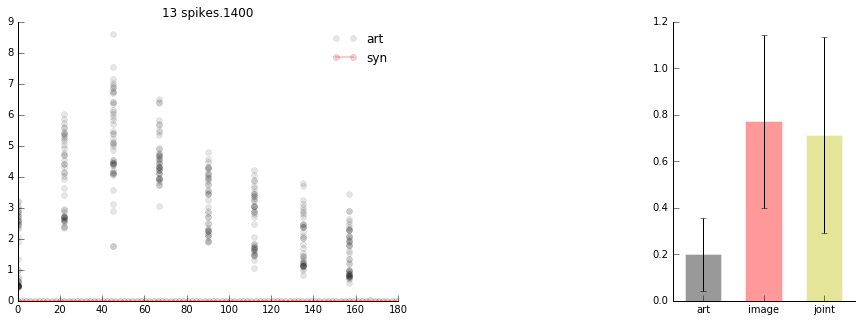

(art, syn): -0.392004


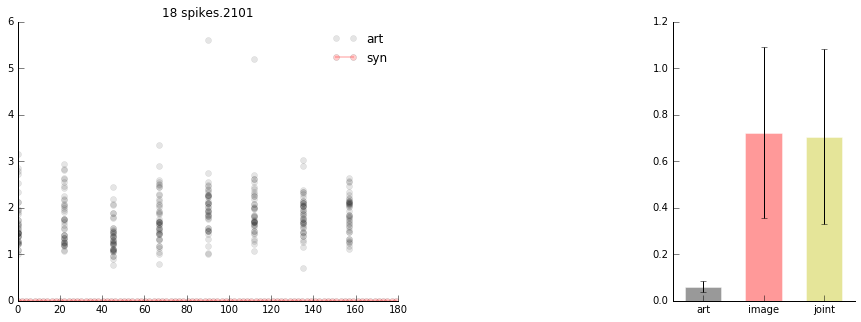

(art, syn): -0.132404


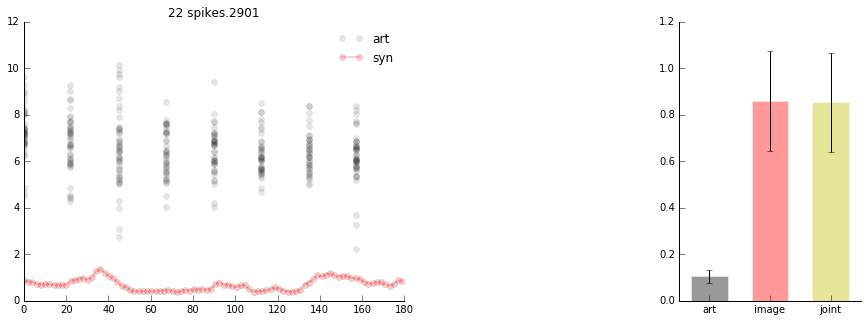

(art, syn): 0.051317


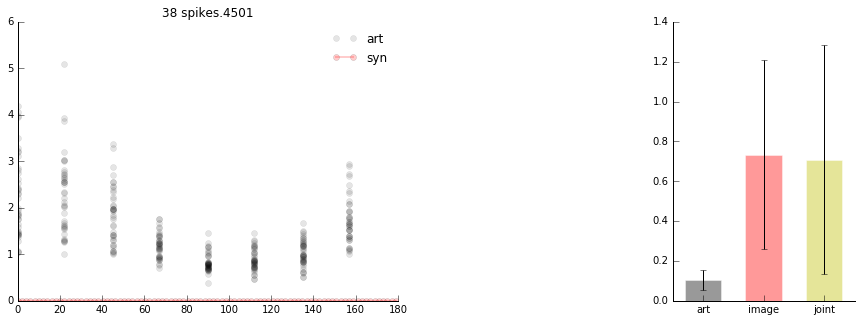

(art, syn): 0.139729


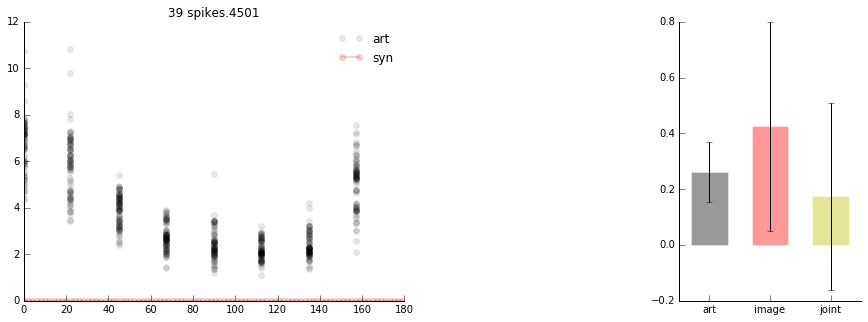

(art, syn): 0.040838


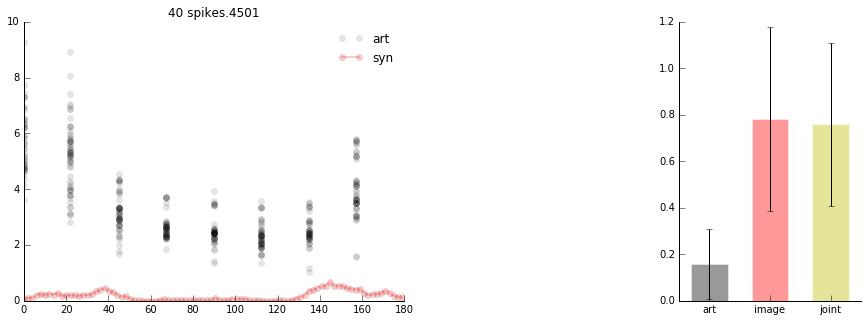

(art, syn): 0.216772


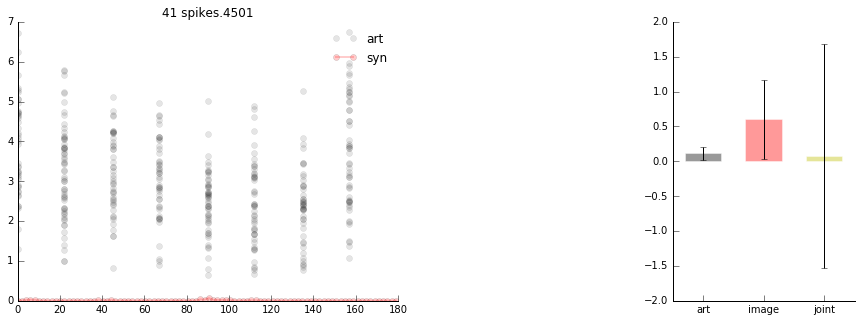

(art, syn): -0.120731


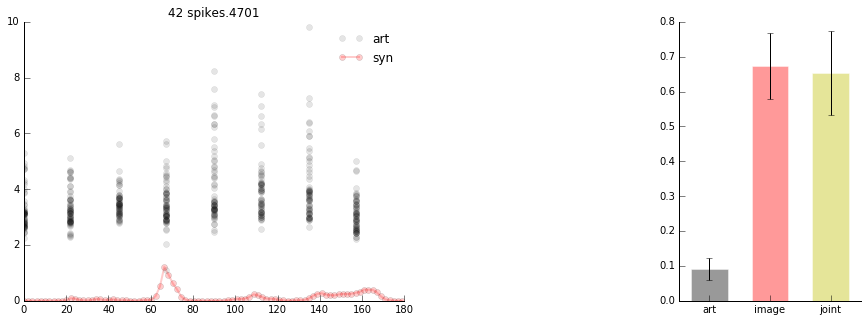

(art, syn): 0.002450


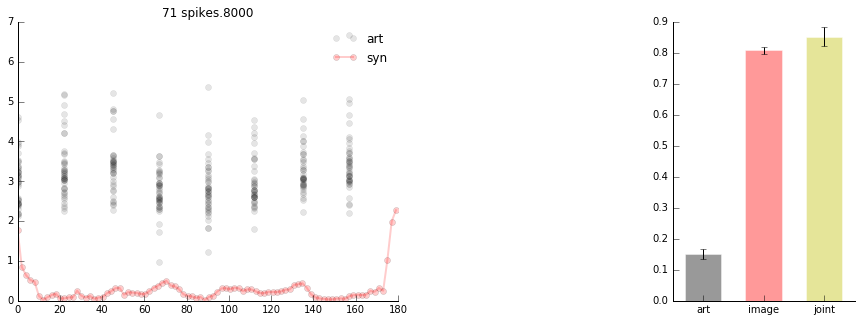

(art, syn): -0.402211


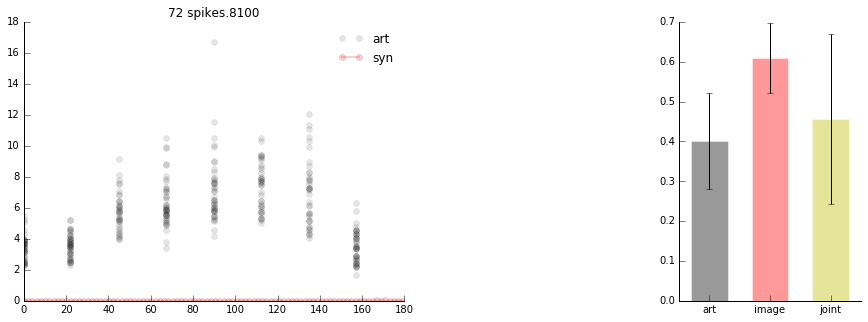

(art, syn): -0.305570


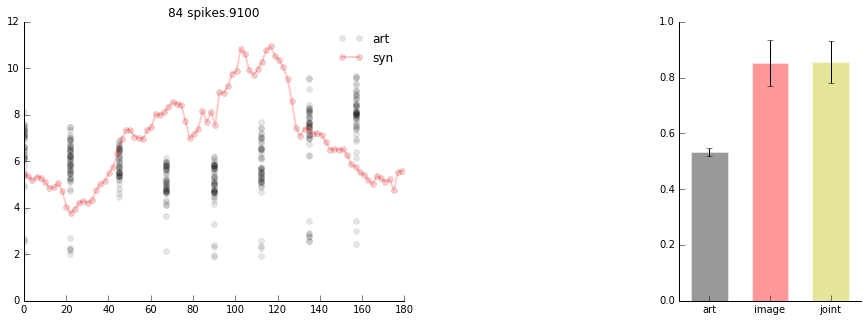

(art, syn): -0.334434


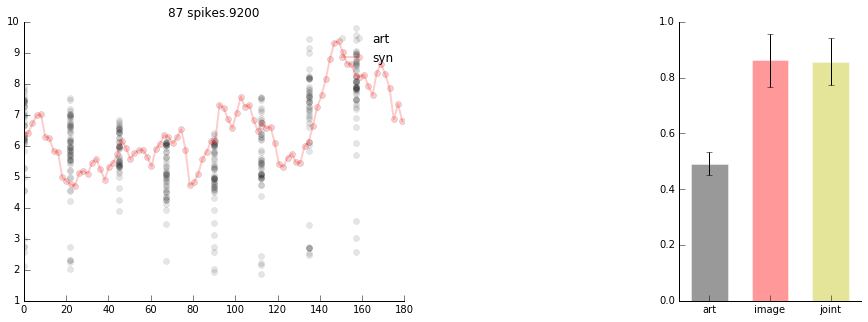

(art, syn): 0.653092


In [47]:
art_syn_corr = list()
        
art_pseudo_R2 = dict()
art_pseudo_R2['mean'] = list()
art_pseudo_R2['std'] = list()
art_model_name = 'art_orientation_model'

syn_pseudo_R2 = dict()
syn_pseudo_R2['mean'] = list()
syn_pseudo_R2['std'] = list()
syn_model_name = 'vggl5_model'
syn_model_prediction = 'vggl5_orientation_prediction'

art_entropy = list()
syn_entropy = list()

for neuron_id, neuron_name in enumerate(df_results_all['name']):
#for neuron_id in [12, 13, 14, 34, 38, 39, 40, 41, 72, 76, 77, 84, 85, 86, 87]:
    #neuron_id = 40
    #neuron_name = 'spikes.4501'
    neuron_name = df_neurons.loc[neuron_id]['name']
    if ((np.mean(df_results_all[syn_model_name][neuron_id]['image_model']['pseudo_R2']) - \
         1.96 * np.std(df_results_all[syn_model_name][neuron_id]['image_model']['pseudo_R2']) > 0.) & \
        (np.mean(df_results_all[art_model_name][neuron_id]['pseudo_R2']) - \
         1.96 * np.std(df_results_all[art_model_name][neuron_id]['pseudo_R2']) > 0.)):
    #if(True):
        plt.figure(figsize=(15,5))


        # Collect all pseudo R2s
        art_pseudo_R2['mean'].append(np.mean(df_results_all[art_model_name][neuron_id]['pseudo_R2']))
        art_pseudo_R2['std'].append(np.std(df_results_all[art_model_name][neuron_id]['pseudo_R2']))
        syn_pseudo_R2['mean'].append(np.mean(df_results_all[syn_model_name][neuron_id]['image_model']['pseudo_R2']))
        syn_pseudo_R2['std'].append(np.std(df_results_all[syn_model_name][neuron_id]['image_model']['pseudo_R2']))

        ax = plt.subplot(121)
        V4.simpleaxis(ax)

        # Fit a polynomial to the art tuning curve
        f_poly = np.poly1d(np.polyfit(df_results_all[art_model_name][neuron_id]['ori'], 
                  df_results_all[art_model_name][neuron_id]['predicted_spike_counts'],
                  5))        
        art_grating_ori = f_poly(df_results_all[syn_model_prediction][neuron_id]['ori'])

        # Plot art
        ax.plot(df_results_all[art_model_name][neuron_id]['ori'], 
                df_results_all[art_model_name][neuron_id]['predicted_spike_counts'], 'ko', alpha=0.1)

        # Plot syn
        #ax.plot(df_results_all[syn_model_prediction][neuron_id]['ori'], 
        #        df_results_all[syn_model_prediction][neuron_id]['joint_predicted_spike_counts'], 'yo-', alpha=0.2, lw=2)
        ax.plot(df_results_all[syn_model_prediction][neuron_id]['ori'], 
                df_results_all[syn_model_prediction][neuron_id]['image_predicted_spike_counts'], 'ro-', alpha=0.2, lw=2)
        ax.legend(['art', 'syn'], frameon=False)
        plt.title(str(neuron_id)+' '+neuron_name)

        ax= plt.subplot(144)
        V4.simpleaxis(ax)
        ax.bar(left=[1, 2, 3], width=0.6, align='center', alpha=0.4,
               height=[np.mean(df_results_all[art_model_name][neuron_id]['pseudo_R2']),
                       np.mean(df_results_all[syn_model_name][neuron_id]['image_model']['pseudo_R2']),
                       np.mean(df_results_all[syn_model_name][neuron_id]['joint_model']['pseudo_R2'])],
               yerr=[1.96*np.std(df_results_all[art_model_name][neuron_id]['pseudo_R2']),
                     1.96*np.std(df_results_all[syn_model_name][neuron_id]['image_model']['pseudo_R2']),
                     1.96*np.std(df_results_all[syn_model_name][neuron_id]['joint_model']['pseudo_R2'])],
               color=['k', 'r', 'y'], ecolor='k', ec='w', tick_label=['art', 'image', 'joint'])

        #plt.savefig('../04-figures_cosyne2017/tune_'+re.split('\.', neuron_name)[-1]+'_'+str(neuron_id)+'.pdf', format='pdf')
        plt.show()

        # Compute and display correlations
        this_art_syn_corr = np.corrcoef(art_grating_ori, 
                                        df_results_all[syn_model_prediction][neuron_id]['image_predicted_spike_counts'])[0,1]
        art_syn_corr.append(this_art_syn_corr)

        print "(art, syn): %f" % this_art_syn_corr

        # Compute entropy as a measure of tuning
        tune = art_grating_ori
        #art_entropy.append(-np.sum(tune * np.log(tune)))
        art_entropy.append(tune.max() - tune.min())
        tune = df_results_all[syn_model_prediction][neuron_id]['image_predicted_spike_counts']
        syn_entropy.append(tune.max() - tune.min())

art_syn_corr = np.array(art_syn_corr)

In [111]:
for neuron_id, neuron_name in enumerate(df_fits_all['name']):
    print neuron_id, neuron_name

NameError: name 'df_fits_all' is not defined

In [237]:
#import re
re.split('\.', neuron_name)[-1]
#neuron_name

'9600'

In [68]:
#df_results_all[syn_model_name][neuron_id]['image_model']['pseudo_R2']
#df_results_all[syn_model_prediction][neuron_id]
df_results_all[syn_model_name][neuron_id]['image_model']['pseudo_R2']

[0.034608526658101435,
 0.043019797445653318,
 0.026044700189681191,
 0.015971522125509674,
 0.0089501939112437423,
 0.018007935774282946,
 0.053094521178611687,
 0.046181453181890597,
 0.021803912990028707,
 0.028340811436642022]

### Summary: mean +/ 2 std correlation between tuning curves

In [48]:
print '%6.4f +/- %6.4f' % (np.mean(art_syn_corr), 2 * np.std(art_syn_corr) / np.sqrt(len(art_syn_corr)))

-0.0478 +/- 0.1552


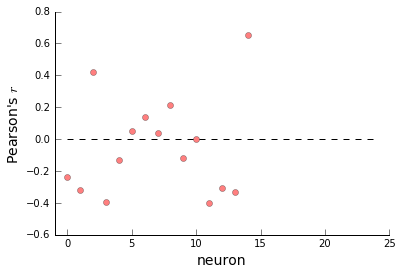

In [49]:
plt.figure()
ax = plt.subplot(111)
V4.simpleaxis(ax)
ax.plot(art_syn_corr, 'ro', alpha=0.5)
ax.plot(np.arange(25), np.zeros(25), 'k--')
plt.xlim([-1, 25])
plt.xlabel('neuron', fontsize=14)
plt.ylabel('Pearson\'s $r$' , fontsize=14)

#plt.savefig('population_Pearsons_r.pdf', format='pdf')
plt.show()

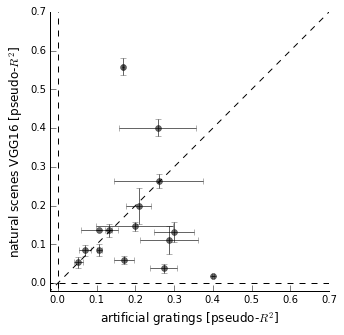

In [68]:
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
V4.simpleaxis(ax)
#ax.errorbar(x=np.array(art_pseudo_R2['mean']), y=np.array(nat_pseudo_R2['mean']), 
#             xerr=np.array(art_pseudo_R2['std']), yerr=np.array(nat_pseudo_R2['std']), fmt='go', alpha=0.3)
ax.errorbar(x=np.array(art_pseudo_R2['mean']), y=np.array(syn_pseudo_R2['mean']), 
             xerr=np.array(art_pseudo_R2['std']), yerr=np.array(syn_pseudo_R2['std']), fmt='ko', alpha=0.6)
ax.plot(np.linspace(-1., 1., 10), np.linspace(-1., 1., 10), 'k--')
ax.plot(np.linspace(-1., 1., 10), np.zeros(10), 'k--')
ax.plot(np.zeros(10), np.linspace(-1., 1., 10), 'k--')
ax.axis([-0.02, 0.7, -0.02, 0.7])
plt.xlabel('artificial gratings [pseudo-$R^2$]', fontsize=12)
plt.ylabel('natural scenes VGG16 [pseudo-$R^2$]', fontsize=12)

#plt.savefig('art_vs_nat_pseudoR2s.pdf', format='pdf')
plt.show()

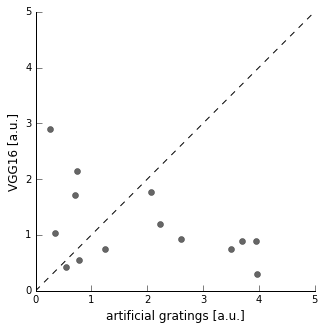

In [69]:
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
V4.simpleaxis(ax)
ax.plot(np.array(art_entropy), np.array(syn_entropy), 'ko', alpha=0.6)
ax.plot(np.linspace(0, 5, 10), np.linspace(0, 5, 10), 'k--')
#ax.plot(np.linspace(0, 5, 10), np.zeros(10), 'k--')
#ax.plot(np.zeros(10), np.linspace(-500, 3500, 10), 'k--')
ax.axis([0, 5, 0, 5])
plt.xlabel('artificial gratings [a.u.]', fontsize=12)
plt.ylabel('VGG16 [a.u.]', fontsize=12)

#plt.savefig('population_mod_depth.pdf', format='pdf')
plt.show()

In [52]:
syn_pseudo_R2['mean']

[0.55737328743026127,
 0.18894179203667832,
 0.11378399833809412,
 0.13227183688969668,
 0.047177100257969409,
 0.26351618913148495,
 0.087057116146126837,
 0.40530936243621757,
 0.037964713109712972,
 0.0657024976505097,
 0.07852439381793537,
 0.13671445688163503,
 0.020505832614903963,
 0.13637367929685046,
 0.12543689618788742]

In [163]:
def hsv_to_rgb(hue=0, sat=255, val=25):
    hsv = np.array([hue, sat, val])
    im = np.zeros((1,1,3))
    im[0, 0, :] = hsv
    im = im.astype(np.uint8)
    rgb = cv2.cvtColor(im, cv2.COLOR_HSV2RGB)
    return rgb[0, 0]

In [72]:
def show_tuning_as_color_strip(tune_art, tune_nat, tune_syn, neuron_name='neuron'):
    n_hues = tune_art.shape[0]
    im = 255. * np.ones((160, n_hues, 3))
        
    mx = np.max([tune_art.max(), tune_nat.max(), tune_syn.max()])
    for hue, art_hue_fr in enumerate(tune_art):    
        norm_fr = art_hue_fr / mx * 255
        for row in range(40):
            im[row, hue, :] = hsv_to_rgb(hue=hue/2, sat=255, val=norm_fr)

    for hue, nat_hue_fr in enumerate(tune_nat):    
        norm_fr = nat_hue_fr / mx * 255
        for row in range(40):
            im[60+row, hue, :] = hsv_to_rgb(hue=hue/2, sat=255, val=norm_fr)
            
    for hue, syn_hue_fr in enumerate(tune_syn):    
        norm_fr = syn_hue_fr / mx * 255
        for row in range(40):
            im[120+row, hue, :] = hsv_to_rgb(hue=hue/2, sat=255, val=norm_fr)
        
    # Plot firing rate
    plt.imshow(im.astype(np.uint8), interpolation='none')
    plt.title(neuron_name)
    plt.axis('off')

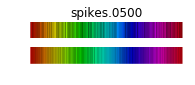

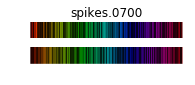

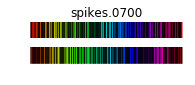

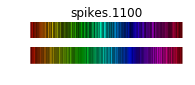

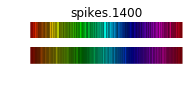

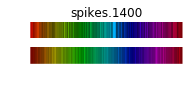

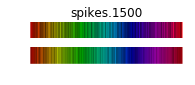

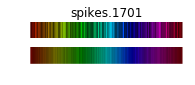

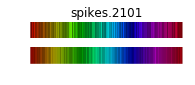

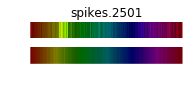

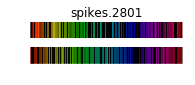

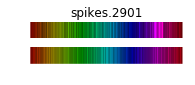

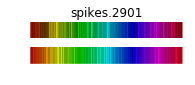

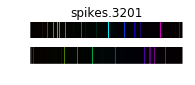

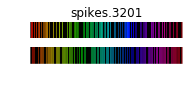

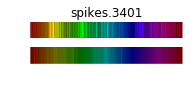

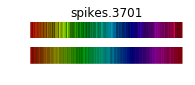

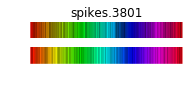

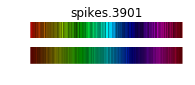

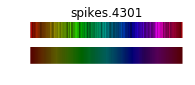

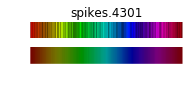

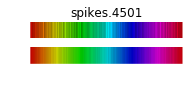

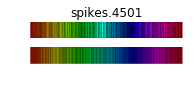

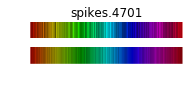

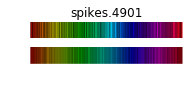

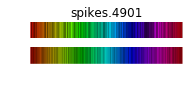

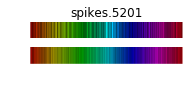

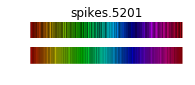

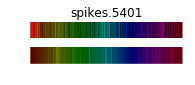

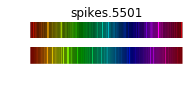

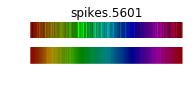

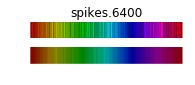

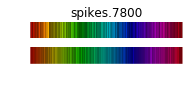

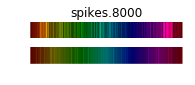

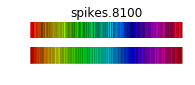

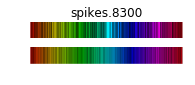

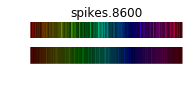

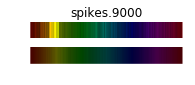

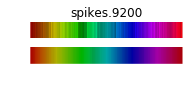

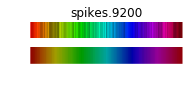

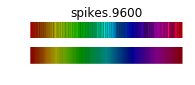

In [63]:
for neuron_id, neuron_name in enumerate(df_neurons['name']):    
    tune_art = df_fits_all['histogram_model'][neuron_id]['plain_predicted_spike_counts']
    tune_nat = df_fits_all['vggl7_model'][neuron_id]['plain_predicted_spike_counts']
    
    if np.mean(df_fits_all['vggl7_model'][neuron_id]['pseudo_R2']) - \
       2. * np.std(df_fits_all['vggl7_model'][neuron_id]['pseudo_R2']) > 0.:
        plt.figure()
        plt.subplot(121)
        show_tuning_as_color_strip(tune_art, tune_nat, neuron_name=neuron_name)

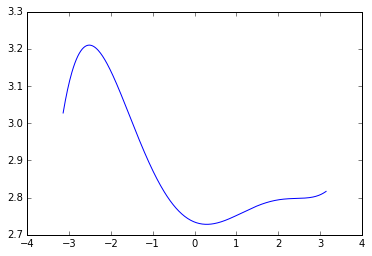

In [95]:
f_tmp = np.poly1d(np.polyfit(df_fits_all['art_model'][neuron_id]['hue'], 
                  df_fits_all['art_model'][neuron_id]['predicted_spike_counts'],
                  5))

# calculate new x's and y's
x_tmp = df_fits_all['histogram_model'][neuron_id]['plain_hue']
y_tmp = f_tmp(x_tmp)
plt.plot(x_tmp, y_tmp)
plt.show()

In [2]:
import pandas as pd
results_all = pd.read_pickle('../02-preprocessed_data/M3/results_all')

In [6]:
results_all['vggl6_model'][0]

{'image_model': {'pseudo_R2': [-0.055129350044801573,
   0.64013406204060264,
   0.72344968424437339,
   0.54167096043299789,
   0.80560357798922522,
   0.83023118908671056,
   0.88195984423764506,
   0.94370291547857965,
   0.89105331484633798,
   0.86842888999834489]},
 'joint_model': {'pseudo_R2': [-0.46973089765544596,
   0.56059275666917552,
   0.7211632974029285,
   0.43141613338192497,
   0.78781651860959911,
   0.78382377094344013,
   0.88891021231213063,
   0.91606912770310411,
   0.88547585420902231,
   0.85032169691274784]}}